<a href="https://colab.research.google.com/github/Saumiyav01/huygvy/blob/main/BreastCancer_Survival_Modelin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load your preprocessed dataset
data_path = '/content/drive/MyDrive/BreastCancer_Survival/processed_data/combined_dataset.csv'
combined = pd.read_csv(data_path)

print("✅ Data loaded successfully! Shape:", combined.shape)
combined.head()


Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/BreastCancer_Survival/processed_data/combined_dataset.csv'

In [ ]:
import os

search_name = 'combined_dataset.csv'
for root, dirs, files in os.walk('/content/drive/MyDrive'):
    for f in files:
        if search_name in f:
            print("Found file:", os.path.join(root, f))



In [ ]:
import pandas as pd

data_path = '/content/drive/MyDrive/BreastCancer_Survival/processed_data/combined_dataset.csv'
combined = pd.read_csv(data_path)

print("✅ Data loaded successfully! Shape:", combined.shape)


/tmp/ipython-input-3654425355.py:4: DtypeWarning: Columns (60665,60672,60677,60694,60723,60728,60824) have mixed types. Specify dtype option on import or set low_memory=False.
  combined = pd.read_csv(data_path)


✅ Data loaded successfully! Shape: (1132, 60873)


In [ ]:

import os
import re
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib


DRIVE_BASE = '/content/drive/MyDrive/BreastCancer_Survival'
PROCESSED_DIR = os.path.join(DRIVE_BASE, 'processed_data')
RNA_TOP_K = 2000   # keep top variance genes (set None to keep all)
TEST_SIZE = 0.30   # 30% holdout -> later split to val/test 50/50 of holdout
VAL_FRACTION_OF_HOLDOUT = 0.5
RANDOM_STATE = 42
META_COLS = {'sample_id','case_submitter_id','event','time','recurrence_status','treatment_response'}
# -----------------------------

os.makedirs(PROCESSED_DIR, exist_ok=True)
print("Saving processed outputs to:", PROCESSED_DIR)

# Load combined dataset (adjust path if different)
combined_path_guess = os.path.join(PROCESSED_DIR, 'combined_dataset.csv')
if not os.path.exists(combined_path_guess):
    # try root drive location
    combined_path_guess = os.path.join(DRIVE_BASE, 'combined_dataset.csv')

if not os.path.exists(combined_path_guess):
    raise FileNotFoundError(f"Couldn't find combined_dataset.csv at expected locations. Checked:\n{os.path.join(PROCESSED_DIR,'combined_dataset.csv')}\n{os.path.join(DRIVE_BASE,'combined_dataset.csv')}\n\nPlease update the path variable combined_path_guess to point to your file.")

combined = pd.read_csv(combined_path_guess)
print("Loaded combined dataset:", combined.shape)

# Basic checks
if 'event' not in combined.columns or 'time' not in combined.columns:
    raise ValueError("Required columns 'event' and 'time' not found in combined dataset. Please ensure these exist.")

n_samples = combined.shape[0]

# Heuristic column classification
all_cols = [c for c in combined.columns if c not in META_COLS]
numeric_cols = combined[all_cols].select_dtypes(include=[np.number]).columns.tolist()
object_cols = combined[all_cols].select_dtypes(include=['object','category']).columns.tolist()

# 1) CNV detection via name heuristics
cnv_name_pattern = re.compile(r'(cnv|copy|copynumber|ascat|gistic|segment|seg|log2ratio)', flags=re.I)
cnv_cols = [c for c in all_cols if cnv_name_pattern.search(c)]
# 2) RNA detection by ensembl/uppercase/gene-like heuristics and dimensionality
ensembl_cols = [c for c in all_cols if str(c).upper().startswith('ENSG')]
upper_gene_like = [c for c in all_cols if (str(c).isupper() and len(str(c))<=20 and not cnv_name_pattern.search(c))]
# numeric continuous likely RNA if very high-dimensional
candidate_continuous = [c for c in numeric_cols if c not in cnv_cols]
# determine RNA block:
if len(ensembl_cols) > 0:
    rna_cols = ensembl_cols
elif len(candidate_continuous) >= 500:
    # assume highest variance continuous features are RNA-like
    # compute variance quickly (skip tiny NAs)
    var_series = combined[candidate_continuous].var(axis=0, skipna=True)
    # choose top K or all
    if RNA_TOP_K and len(var_series) > RNA_TOP_K:
        rna_cols = var_series.sort_values(ascending=False).index[:RNA_TOP_K].tolist()
    else:
        rna_cols = var_series.sort_values(ascending=False).index.tolist()
else:
    # fallback: use columns with names that look like genes (letters only, length 2..10)
    gene_like = [c for c in all_cols if re.match(r'^[A-Za-z0-9\-_.]{2,15}$', str(c)) and c not in cnv_cols]
    rna_cols = gene_like[:min(len(gene_like), RNA_TOP_K or len(gene_like))]

# Remove any overlap
rna_cols = [c for c in rna_cols if c not in cnv_cols]
# remaining numeric columns (non-RNA, non-CNV) -> clinical numeric
clinical_numeric = [c for c in numeric_cols if c not in rna_cols and c not in cnv_cols]
# remaining object/categorical -> clinical categorical
clinical_categorical = [c for c in object_cols if c not in rna_cols and c not in cnv_cols]

# Final tidy-up: if too few rna columns, fall back to candidate_continuous top features
if len(rna_cols) < 50 and len(candidate_continuous) > 50:
    var_series = combined[candidate_continuous].var(axis=0, skipna=True)
    take_k = min(len(var_series), RNA_TOP_K or len(var_series))
    rna_cols = var_series.sort_values(ascending=False).index[:take_k].tolist()
    clinical_numeric = [c for c in numeric_cols if c not in rna_cols and c not in cnv_cols]

print(f"Detected blocks sizes -> RNA: {len(rna_cols)}, CNV: {len(cnv_cols)}, Clinical numeric: {len(clinical_numeric)}, Clinical categorical: {len(clinical_categorical)}")

# Build DataFrames for each block
rna_df = combined[rna_cols].copy() if len(rna_cols)>0 else pd.DataFrame(index=combined.index)
cnv_df = combined[cnv_cols].copy() if len(cnv_cols)>0 else pd.DataFrame(index=combined.index)
clin_num_df = combined[clinical_numeric].copy() if len(clinical_numeric)>0 else pd.DataFrame(index=combined.index)
clin_cat_df = combined[clinical_categorical].copy() if len(clinical_categorical)>0 else pd.DataFrame(index=combined.index)

# Quick diagnostics
print("RNA example columns (first 10):", rna_df.columns.tolist()[:10])
print("CNV example columns (first 10):", cnv_df.columns.tolist()[:10])
print("Clinical numeric (first 10):", clin_num_df.columns.tolist()[:10])
print("Clinical categorical (first 10):", clin_cat_df.columns.tolist()[:10])

# -------- Imputation --------
# Numeric imputer (median)
num_imputer = SimpleImputer(strategy='median')
if not rna_df.empty:
    rna_imputed = pd.DataFrame(num_imputer.fit_transform(rna_df), columns=rna_df.columns, index=combined.index)
else:
    rna_imputed = rna_df.copy()

if not cnv_df.empty:
    cnv_imputed = pd.DataFrame(num_imputer.fit_transform(cnv_df), columns=cnv_df.columns, index=combined.index)
else:
    cnv_imputed = cnv_df.copy()

if not clin_num_df.empty:
    clin_num_imputed = pd.DataFrame(num_imputer.fit_transform(clin_num_df), columns=clin_num_df.columns, index=combined.index)
else:
    clin_num_imputed = clin_num_df.copy()

# Categorical: fill with mode and one-hot encode
cat_imputer = SimpleImputer(strategy='most_frequent')
if not clin_cat_df.empty:
    clin_cat_filled = pd.DataFrame(cat_imputer.fit_transform(clin_cat_df), columns=clin_cat_df.columns, index=combined.index)
    clin_cat_encoded = pd.get_dummies(clin_cat_filled.astype(str), drop_first=True)
else:
    clin_cat_encoded = pd.DataFrame(index=combined.index)

# -------- Scaling --------
rna_scaler = StandardScaler()
cnv_scaler = StandardScaler()
clin_scaler = StandardScaler()

if not rna_imputed.empty:
    rna_scaled = pd.DataFrame(rna_scaler.fit_transform(rna_imputed), columns=rna_imputed.columns, index=combined.index)
else:
    rna_scaled = rna_imputed.copy()

if not cnv_imputed.empty:
    cnv_scaled = pd.DataFrame(cnv_scaler.fit_transform(cnv_imputed), columns=cnv_imputed.columns, index=combined.index)
else:
    cnv_scaled = cnv_imputed.copy()

if not clin_num_imputed.empty:
    clin_num_scaled = pd.DataFrame(clin_scaler.fit_transform(clin_num_imputed), columns=clin_num_imputed.columns, index=combined.index)
else:
    clin_num_scaled = clin_num_imputed.copy()

# Concatenate final X
X = pd.concat([rna_scaled, cnv_scaled, clin_num_scaled, clin_cat_encoded], axis=1)
print("Final feature matrix X shape:", X.shape)

# Targets
y_event = combined['event'].astype(int).copy()
y_time = combined['time'].astype(float).copy()
# Optional: if recurrence & treatment_response exist, pull them
y_recur = combined['recurrence_status'] if 'recurrence_status' in combined.columns else None
y_resp = combined['treatment_response'] if 'treatment_response' in combined.columns else None

# -------- Train / Val / Test split --------
X_train, X_hold, y_event_train, y_event_hold, y_time_train, y_time_hold = train_test_split(
    X, y_event, y_time, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

# split hold into val/test equally
X_val, X_test, y_event_val, y_event_test, y_time_val, y_time_test = train_test_split(
    X_hold, y_event_hold, y_time_hold, test_size=VAL_FRACTION_OF_HOLDOUT, random_state=RANDOM_STATE, shuffle=True
)

print("Shapes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Events in train/val/test:", y_event_train.sum(), y_event_val.sum(), y_event_test.sum())

# Save CSVs
def save_df(df, name):
    p = os.path.join(PROCESSED_DIR, name)
    df.to_csv(p, index=True)
    print("Saved:", p)

save_df(X_train, 'X_train.csv')
save_df(X_val, 'X_val.csv')
save_df(X_test, 'X_test.csv')

# Save target arrays
pd.DataFrame({'time': y_time_train, 'event': y_event_train}).to_csv(os.path.join(PROCESSED_DIR, 'y_train_survival.csv'), index=True)
pd.DataFrame({'time': y_time_val,   'event': y_event_val}).to_csv(os.path.join(PROCESSED_DIR, 'y_val_survival.csv'), index=True)
pd.DataFrame({'time': y_time_test,  'event': y_event_test}).to_csv(os.path.join(PROCESSED_DIR, 'y_test_survival.csv'), index=True)
print("Saved survival target CSVs.")

# Save recurrence/response if present
if y_recur is not None:
    y_recur_train = y_recur.loc[X_train.index]; y_recur_val = y_recur.loc[X_val.index]; y_recur_test = y_recur.loc[X_test.index]
    pd.DataFrame({'recurrence': y_recur_train}).to_csv(os.path.join(PROCESSED_DIR, 'y_train_recurrence.csv'))
    pd.DataFrame({'recurrence': y_recur_val}).to_csv(os.path.join(PROCESSED_DIR, 'y_val_recurrence.csv'))
    pd.DataFrame({'recurrence': y_recur_test}).to_csv(os.path.join(PROCESSED_DIR, 'y_test_recurrence.csv'))
    print("Saved recurrence targets.")

if y_resp is not None:
    y_resp_train = y_resp.loc[X_train.index]; y_resp_val = y_resp.loc[X_val.index]; y_resp_test = y_resp.loc[X_test.index]
    pd.DataFrame({'response': y_resp_train}).to_csv(os.path.join(PROCESSED_DIR, 'y_train_response.csv'))
    pd.DataFrame({'response': y_resp_val}).to_csv(os.path.join(PROCESSED_DIR, 'y_val_response.csv'))
    pd.DataFrame({'response': y_resp_test}).to_csv(os.path.join(PROCESSED_DIR, 'y_test_response.csv'))
    print("Saved treatment response targets.")

# Save scalers and imputers for reuse
joblib.dump(rna_scaler, os.path.join(PROCESSED_DIR, 'rna_scaler.joblib'))
joblib.dump(cnv_scaler, os.path.join(PROCESSED_DIR, 'cnv_scaler.joblib'))
joblib.dump(clin_scaler, os.path.join(PROCESSED_DIR, 'clin_scaler.joblib'))
joblib.dump(num_imputer, os.path.join(PROCESSED_DIR, 'num_imputer.joblib'))
joblib.dump(cat_imputer, os.path.join(PROCESSED_DIR, 'cat_imputer.joblib'))
print("Saved scalers and imputers.")

# Save a small metadata JSON describing column splits
import json
meta = {
    'rna_cols': rna_scaled.columns.tolist(),
    'cnv_cols': cnv_scaled.columns.tolist(),
    'clinical_numeric_cols': clin_num_scaled.columns.tolist(),
    'clinical_categorical_encoded_cols': clin_cat_encoded.columns.tolist(),
    'X_shape': X.shape,
    'n_samples': n_samples,
    'train_shape': X_train.shape,
    'val_shape': X_val.shape,
    'test_shape': X_test.shape
}
with open(os.path.join(PROCESSED_DIR, 'processing_metadata.json'),'w') as fh:
    json.dump(meta, fh, indent=2)
print("Saved processing metadata.")

print("\n✅ All done. Files written to:", PROCESSED_DIR)


Saving processed outputs to: /content/drive/MyDrive/BreastCancer_Survival/processed_data


/tmp/ipython-input-3334895254.py:32: DtypeWarning: Columns (60665,60672,60677,60694,60723,60728,60824) have mixed types. Specify dtype option on import or set low_memory=False.
  combined = pd.read_csv(combined_path_guess)


Loaded combined dataset: (1132, 60873)
Detected blocks sizes -> RNA: 60660, CNV: 0, Clinical numeric: 4, Clinical categorical: 205
RNA example columns (first 10): ['ENSG00000000003.15', 'ENSG00000000005.6', 'ENSG00000000419.13', 'ENSG00000000457.14', 'ENSG00000000460.17', 'ENSG00000000938.13', 'ENSG00000000971.16', 'ENSG00000001036.14', 'ENSG00000001084.13', 'ENSG00000001167.14']
CNV example columns (first 10): []
Clinical numeric (first 10): ['value', 'demographic.age_at_index', 'demographic.days_to_death', 'diagnoses.days_to_last_follow_up']
Clinical categorical (first 10): ['project.project_id', 'cases.case_id', 'cases.consent_type', 'cases.days_to_consent', 'cases.days_to_lost_to_followup', 'cases.disease_type', 'cases.index_date', 'cases.lost_to_followup', 'cases.primary_site', 'demographic.age_is_obfuscated']
Final feature matrix X shape: (1132, 69986)
Shapes -> Train: (792, 69986) Val: (170, 69986) Test: (170, 69986)
Events in train/val/test: 136 31 29
Saved: /content/drive/MyDr

In [ ]:
!ls '/content/drive/MyDrive/BreastCancer_Survival/processed_data'


cat_imputer.joblib    num_imputer.joblib	X_val.csv
clinical_merged.csv   processing_metadata.json	y_test_survival.csv
clin_scaler.joblib    rna_scaler.joblib		y_train_survival.csv
cnv_scaler.joblib     X_test.csv		y_val_survival.csv
combined_dataset.csv  X_train.csv


In [ ]:
!pip install lifelines --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.4 MB/s eta 0:00:00


In [ ]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter


Shapes -> train: (792, 69988) val: (170, 69988) test: (170, 69988)
Running fast univariate Cox screening to pick top 150 features...
Selected features: 150
Fitting CoxPH model with penalizer = 1.0
Iteration 1: norm_delta = 2.19e-01, step_size = 0.9500, log_lik = -724.39901, newton_decrement = 2.60e+01, seconds_since_start = 0.1
Iteration 2: norm_delta = 1.22e-02, step_size = 0.9500, log_lik = -699.10145, newton_decrement = 1.24e-01, seconds_since_start = 0.2
Iteration 3: norm_delta = 6.64e-04, step_size = 0.9500, log_lik = -698.97727, newton_decrement = 4.06e-04, seconds_since_start = 0.3
Iteration 4: norm_delta = 5.35e-07, step_size = 1.0000, log_lik = -698.97687, newton_decrement = 3.18e-10, seconds_since_start = 0.4
Convergence success after 4 iterations.

--- CoxPH Summary ---


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
treatments.treatment_type_Chemotherapy,-0.146758,0.863503,0.077590,-0.298832,0.005316,0.741684,1.005330,0.0,-1.891454,0.058564,4.093848
"treatments.treatment_type_Surgery, NOS",0.132389,1.141552,0.071694,-0.008128,0.272905,0.991905,1.313776,0.0,1.846593,0.064806,3.947724
"treatments.treatment_type_Pharmaceutical Therapy, NOS",0.216547,1.241781,0.117438,-0.013628,0.446721,0.986465,1.563179,0.0,1.843922,0.065195,3.939106
ENSG00000004846.16,0.056388,1.058008,0.032872,-0.008040,0.120816,0.991992,1.128417,0.0,1.715380,0.086276,3.534905
treatments.treatment_outcome_Progressive Disease,0.672083,1.958313,0.483200,-0.274972,1.619139,0.759593,5.048741,0.0,1.390899,0.164256,2.605983
treatments.treatment_outcome_Complete Response,-0.119786,0.887111,0.102630,-0.320937,0.081366,0.725469,1.084768,0.0,-1.167158,0.243147,2.040101
ENSG00000005469.12,-0.037573,0.963124,0.034083,-0.104374,0.029228,0.900888,1.029659,0.0,-1.102410,0.270283,1.887456
ENSG00000004948.16,0.036873,1.037562,0.035409,-0.032527,0.106273,0.967996,1.112126,0.0,1.041357,0.297710,1.748020
ENSG00000003436.16,0.033776,1.034352,0.033585,-0.032050,0.099601,0.968458,1.104730,0.0,1.005666,0.314576,1.668517


 Saved CoxPH model with joblib to: /content/drive/MyDrive/BreastCancer_Survival/processed_data/coxph_model.joblib
Saved CoxPH summary to: /content/drive/MyDrive/BreastCancer_Survival/processed_data/coxph_summary.csv
Saved selected features to: /content/drive/MyDrive/BreastCancer_Survival/processed_data/cox_selected_features.json
Concordance index -> train: 0.8253, val: 0.5550, test: 0.6622

Top 20 features by p-value:


,coef,HR,se(coef),p,coef lower 95%,coef upper 95%
covariate,,,,,,
treatments.treatment_type_Chemotherapy,-0.146758,0.863503,0.077590,0.058564,-0.298832,0.005316
"treatments.treatment_type_Surgery, NOS",0.132389,1.141552,0.071694,0.064806,-0.008128,0.272905
"treatments.treatment_type_Pharmaceutical Therapy, NOS",0.216547,1.241781,0.117438,0.065195,-0.013628,0.446721
ENSG00000004846.16,0.056388,1.058008,0.032872,0.086276,-0.008040,0.120816
treatments.treatment_outcome_Progressive Disease,0.672083,1.958313,0.483200,0.164256,-0.274972,1.619139
treatments.treatment_outcome_Complete Response,-0.119786,0.887111,0.102630,0.243147,-0.320937,0.081366
ENSG00000005469.12,-0.037573,0.963124,0.034083,0.270283,-0.104374,0.029228
ENSG00000004948.16,0.036873,1.037562,0.035409,0.297710,-0.032527,0.106273
ENSG00000003436.16,0.033776,1.034352,0.033585,0.314576,-0.032050,0.099601


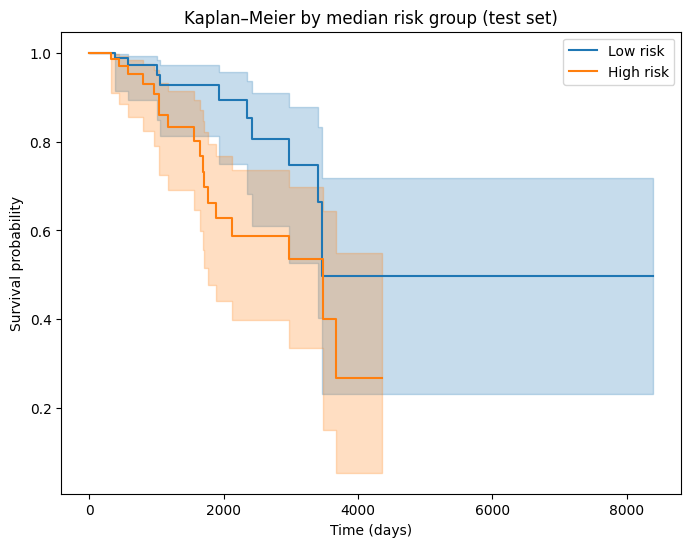


Running proportional hazards check (this may take a moment)...
Proportional hazard assumption looks okay.
check_assumptions completed. Inspect warnings above if any.
Brier score at 1 year (365 days) on test set: 0.0064

✅ CoxPH training & evaluation completed. Model and summary are saved in: /content/drive/MyDrive/BreastCancer_Survival/processed_data


from matplotlib import pyplot as plt
_df_0['coef'].plot(kind='hist', bins=20, title='coef')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['HR'].plot(kind='hist', bins=20, title='HR')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['se(coef)'].plot(kind='hist', bins=20, title='se(coef)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['p'].plot(kind='hist', bins=20, title='p')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='coef', y='HR', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='HR', y='se(coef)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='se(coef)', y='p', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='p', y='coef lower 95%', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['p']
  ys = series['coef']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('p', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('p')
_ = plt.ylabel('coef')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['p']
  ys = series['HR']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('p', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('p')
_ = plt.ylabel('HR')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['p']
  ys = series['se(coef)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('p', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('p')
_ = plt.ylabel('se(coef)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['p']
  ys = series['coef lower 95%']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('p', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('p')
_ = plt.ylabel('coef lower 95%')

from matplotlib import pyplot as plt
_df_12['coef'].plot(kind='line', figsize=(8, 4), title='coef')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['HR'].plot(kind='line', figsize=(8, 4), title='HR')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['se(coef)'].plot(kind='line', figsize=(8, 4), title='se(coef)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['p'].plot(kind='line', figsize=(8, 4), title='p')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
import joblib
import warnings
warnings.filterwarnings("ignore")

# ---------- USER CONFIG ----------
DRIVE_BASE = '/content/drive/MyDrive/BreastCancer_Survival'
PROCESSED_DIR = os.path.join(DRIVE_BASE, 'processed_data')
TOP_K_FEATURES = 150   # set to None to use all features (not recommended with thousands)
PENALIZER = 1.0        # L2 penalizer strength (increase to regularize more)
RANDOM_STATE = 42
# ---------------------------------

# --- Load feature matrices and survival targets ---
X_train = pd.read_csv(os.path.join(PROCESSED_DIR, 'X_train.csv'), index_col=0)
X_val   = pd.read_csv(os.path.join(PROCESSED_DIR, 'X_val.csv'), index_col=0)
X_test  = pd.read_csv(os.path.join(PROCESSED_DIR, 'X_test.csv'), index_col=0)

y_train = pd.read_csv(os.path.join(PROCESSED_DIR, 'y_train_survival.csv'), index_col=0)
y_val   = pd.read_csv(os.path.join(PROCESSED_DIR, 'y_val_survival.csv'), index_col=0)
y_test  = pd.read_csv(os.path.join(PROCESSED_DIR, 'y_test_survival.csv'), index_col=0)

# Ensure index alignment
X_train.index = X_train.index.astype(str)
X_val.index   = X_val.index.astype(str)
X_test.index  = X_test.index.astype(str)
y_train.index = y_train.index.astype(str)
y_val.index   = y_val.index.astype(str)
y_test.index  = y_test.index.astype(str)

# Combine X and y into lifelines dataframe format: must contain 'time' and 'event'
train_df = pd.concat([y_train, X_train], axis=1)
train_df = train_df.rename(columns={train_df.columns[0]: 'time', train_df.columns[1]: 'event'}) if list(y_train.shape)[1] >= 2 and 'time' not in y_train.columns else train_df
train_df.columns = ['time','event'] + list(train_df.columns[2:]) if list(train_df.columns[:2]) != ['time','event'] else list(train_df.columns)

val_df = pd.concat([y_val, X_val], axis=1)
test_df = pd.concat([y_test, X_test], axis=1)

print("Shapes -> train:", train_df.shape, "val:", val_df.shape, "test:", test_df.shape)

# --- Optional: univariate Cox filter to pick top features by significance ---
if TOP_K_FEATURES is not None and TOP_K_FEATURES > 0:
    print(f"Running fast univariate Cox screening to pick top {TOP_K_FEATURES} features...")
    pvals = {}
    # For speed we compute simple univariate Cox for each feature; it's fast for a few thousand features
    from lifelines import CoxPHFitter
    for col in X_train.columns:
        try:
            tmp = train_df[['time', 'event', col]].dropna()
            cph_tmp = CoxPHFitter(penalizer=0.0)
            cph_tmp.fit(tmp, duration_col='time', event_col='event', show_progress=False, step_size=0.1)
            p = cph_tmp.summary.loc[col, 'p']
            pvals[col] = p
        except Exception:
            pvals[col] = 1.0
    pvals_series = pd.Series(pvals).sort_values()
    selected_features = pvals_series.index[:min(TOP_K_FEATURES, len(pvals_series))].tolist()
    print("Selected features:", len(selected_features))
else:
    selected_features = X_train.columns.tolist()
    print("Using all features:", len(selected_features))

# --- Build final DataFrames using selected features ---
train_final = train_df[['time','event'] + selected_features].dropna()
val_final   = pd.concat([y_val, X_val[selected_features]], axis=1).dropna()
test_final  = pd.concat([y_test, X_test[selected_features]], axis=1).dropna()

# --- Fit penalized CoxPH (lifelines) ---
cph = CoxPHFitter(penalizer=PENALIZER)
print("Fitting CoxPH model with penalizer =", PENALIZER)
cph.fit(train_final, duration_col='time', event_col='event', show_progress=True)
print("\n--- CoxPH Summary ---")
display(cph.summary.sort_values('p', ascending=True).head(20))

# --- Save model ---
# --- Save model and metadata ---
import joblib, json

model_path = os.path.join(PROCESSED_DIR, 'coxph_model.joblib')
joblib.dump(cph, model_path)
print(" Saved CoxPH model with joblib to:", model_path)

# Save summary
summary_df = cph.summary.copy()
summary_df['HR'] = np.exp(summary_df['coef'])
summary_df = summary_df.sort_values('p')
summary_csv = os.path.join(PROCESSED_DIR, 'coxph_summary.csv')
summary_df.to_csv(summary_csv)
print("Saved CoxPH summary to:", summary_csv)

# Save feature list
selected_features_path = os.path.join(PROCESSED_DIR, 'cox_selected_features.json')
try:
    selected_features
except NameError:
    selected_features = X_train.columns.tolist()
with open(selected_features_path, 'w') as fh:
    json.dump(selected_features, fh)
print("Saved selected features to:", selected_features_path)


# --- Predict risk (partial hazard) and compute concordance index on sets ---
def eval_cox(cph_model, df, split_name='val'):
    X_df = df.copy()
    times = X_df['time'].values
    events = X_df['event'].values
    X_only = X_df.drop(columns=['time','event'])
    # lifelines: higher partial_hazard => higher risk
    partial_hazard = cph_model.predict_partial_hazard(X_df).values.flatten()
    cidx = concordance_index(times, -partial_hazard, events)  # negative because concordance expects higher score=longer survival
    return partial_hazard, cidx

ph_train, cidx_train = eval_cox(cph, train_final, 'train')
ph_val,   cidx_val   = eval_cox(cph, val_final, 'val')
ph_test,  cidx_test  = eval_cox(cph, test_final, 'test')

print(f"Concordance index -> train: {cidx_train:.4f}, val: {cidx_val:.4f}, test: {cidx_test:.4f}")

# --- Interpretation: hazard ratios and top features ---
summary_df = cph.summary.copy()
summary_df['HR'] = np.exp(summary_df['coef'])
summary_df = summary_df.sort_values(by='p', ascending=True)
print("\nTop 20 features by p-value:")
display(summary_df.head(20)[['coef','HR','se(coef)','p','coef lower 95%','coef upper 95%']])

# --- Risk stratification: median split and KM plot on test set ---
test_final = test_final.copy()
test_final['risk_score'] = ph_test  # higher = higher risk
median_risk = np.median(test_final['risk_score'])
test_final['risk_group'] = (test_final['risk_score'] >= median_risk).astype(int)

kmf = KaplanMeierFitter()
plt.figure(figsize=(8,6))
for group,label in [(0,'Low risk'), (1,'High risk')]:
    idx = test_final['risk_group']==group
    kmf.fit(test_final.loc[idx,'time'], event_observed=test_final.loc[idx,'event'], label=label)
    kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan–Meier by median risk group (test set)")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.show()

# --- Check proportional hazards assumption (optional, may be heavy) ---
print("\nRunning proportional hazards check (this may take a moment)...")
try:
    check_df = cph.check_assumptions(train_final, p_value_threshold=0.05, show_plots=False)
    print("check_assumptions completed. Inspect warnings above if any.")
except Exception as e:
    print("check_assumptions failed or produced warnings:", e)

# --- Simple calibration: compute Brier score at one timepoint (e.g., 365 days) ---
def brier_score_at_time(cph_model, df, t0=365):
    # compute survival probability at t0 for each subject
    surv = cph_model.predict_survival_function(df.drop(columns=['time','event']), times=[t0]).T
    probs = surv[t0].values  # probability of surviving past t0
    # event by t0 (1 if dead on or before t0)
    y_event_t0 = (df['time'] <= t0) & (df['event']==1)
    # Brier for binary: mean((pred - obs)^2)
    brier = np.mean((probs - (1 - y_event_t0.astype(int)))**2)  # predict survival prob vs observed survival (1-obs_event_t0)
    return brier

brier_365 = brier_score_at_time(cph, test_final, t0=365)
print(f"Brier score at 1 year (365 days) on test set: {brier_365:.4f}")

print("\n✅ CoxPH training & evaluation completed. Model and summary are saved in:", PROCESSED_DIR)

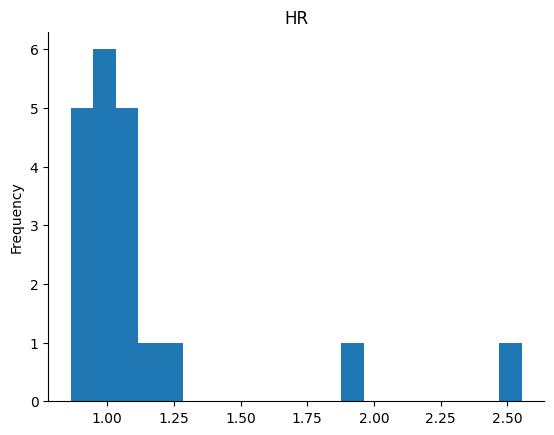

In [ ]:
from matplotlib import pyplot as plt
_df_1['HR'].plot(kind='hist', bins=20, title='HR')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Robust display of CoxPH summary (handles different lifelines versions)
import pandas as pd
import os, json, numpy as np

PROCESSED_DIR = '/content/drive/MyDrive/BreastCancer_Survival/processed_data'
# assume `cph` exists in the runtime (fitted object)
summary_df = cph.summary.copy()

print("Available columns in cph.summary:\n", summary_df.columns.tolist())

# Create HR column if missing
if 'HR' not in summary_df.columns:
    try:
        summary_df['HR'] = np.exp(summary_df['coef'])
    except Exception:
        # fallback: if coef missing (unlikely), skip HR
        pass

# Try to find CI column names (common variants)
ci_lower_candidates = [c for c in summary_df.columns if 'lower' in c.lower() or 'ci' in c.lower() and 'lower' in c.lower()]
ci_upper_candidates = [c for c in summary_df.columns if 'upper' in c.lower() or 'ci' in c.lower() and 'upper' in c.lower()]

# Another common pattern: 'lower 95%' or 'lower-bound 95%' or 'coef lower 95%'
if not ci_lower_candidates:
    ci_lower_candidates = [c for c in summary_df.columns if '0.95' in c or '95' in c and 'lower' in c.lower()]
if not ci_upper_candidates:
    ci_upper_candidates = [c for c in summary_df.columns if '0.95' in c or '95' in c and 'upper' in c.lower()]

ci_lower = ci_lower_candidates[0] if ci_lower_candidates else None
ci_upper = ci_upper_candidates[0] if ci_upper_candidates else None

# Build list of columns to display
display_cols = []
for col in ['coef', 'HR', 'se(coef)', 'p']:
    if col in summary_df.columns:
        display_cols.append(col)
# add CI columns if found
if ci_lower:
    display_cols.append(ci_lower)
if ci_upper:
    display_cols.append(ci_upper)

# Fallback: if none of the base cols found, show first few columns
if not display_cols:
    display_cols = summary_df.columns.tolist()[:6]

print("\nDisplaying columns:", display_cols)
top20 = summary_df.sort_values(by='p' if 'p' in summary_df.columns else summary_df.columns[0]).head(20)
display(top20[display_cols])

# Save a copy for inspection
out_csv = os.path.join(PROCESSED_DIR, 'coxph_summary_adapted_display.csv')
top20[display_cols].to_csv(out_csv)
print("\nSaved adapted top20 summary to:", out_csv)


Available columns in cph.summary:
 ['coef', 'exp(coef)', 'se(coef)', 'coef lower 95%', 'coef upper 95%', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'cmp to', 'z', 'p', '-log2(p)']

Displaying columns: ['coef', 'HR', 'se(coef)', 'p', 'coef lower 95%', 'coef upper 95%']


,coef,HR,se(coef),p,coef lower 95%,coef upper 95%
covariate,,,,,,
treatments.treatment_type_Chemotherapy,-0.146758,0.863503,0.077590,0.058564,-0.298832,0.005316
"treatments.treatment_type_Surgery, NOS",0.132389,1.141552,0.071694,0.064806,-0.008128,0.272905
"treatments.treatment_type_Pharmaceutical Therapy, NOS",0.216547,1.241781,0.117438,0.065195,-0.013628,0.446721
ENSG00000004846.16,0.056388,1.058008,0.032872,0.086276,-0.008040,0.120816
treatments.treatment_outcome_Progressive Disease,0.672083,1.958313,0.483200,0.164256,-0.274972,1.619139
treatments.treatment_outcome_Complete Response,-0.119786,0.887111,0.102630,0.243147,-0.320937,0.081366
ENSG00000005469.12,-0.037573,0.963124,0.034083,0.270283,-0.104374,0.029228
ENSG00000004948.16,0.036873,1.037562,0.035409,0.297710,-0.032527,0.106273
ENSG00000003436.16,0.033776,1.034352,0.033585,0.314576,-0.032050,0.099601



Saved adapted top20 summary to: /content/drive/MyDrive/BreastCancer_Survival/processed_data/coxph_summary_adapted_display.csv


In [ ]:
!pip install scikit-survival xgboost shap lifelines --quiet
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
import shap
import matplotlib.pyplot as plt


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.0 MB/s eta 0:00:00


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BreastCancer_Survival/final_ready_dataset.csv')


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/BreastCancer_Survival/final_ready_dataset.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/BreastCancer_Survival/"


In [ ]:
data = pd.read_csv(base_path + "combined_dataset.csv")
print(" Data loaded successfully:", data.shape)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/BreastCancer_Survival/combined_dataset.csv'

In [ ]:
!ls "/content/drive/MyDrive"



'10th marksheet.jpg'
'12th marksheet.jpg'
 1728238423282.jpg
 1728238423290.jpg
 1728238726402.jpg
'aadhar. pdf.pdf'
'agentic shiiit.gdoc'
'AI ASSIGNMENT 1 (1).gdoc'
'AI ASSIGNMENT 1.docx'
'AI ASSIGNMENT 1.gdoc'
'apthw (1).pdf'
 apthw.pdf
'Aptitude Book RS Agarwal (1).gdoc'
'Aptitude Book RS Agarwal.gdoc'
'assignment 1 OP.pdf'
'assignment 2 (1).pdf'
'Assignment 2 op.pdf'
'assignment 2.pdf'
'assignment 3'
'assignment 3 op.pdf'
 assignment4
 assignment.mp4
 assignment.pdf
'Black and White Corporate Business Proposal Presentation (1).pdf'
 BreastCancer_Survival
'CAREFLEET PITCH DECK'
'CAREFLEET PITCH DECK (1)'
'CAREFLEET PITCH DECK (2)'
 Classroom
'Colab Notebooks'
'community certificate - Saumiya.jpg'
'CS4102-C++ -UPC QUESTIONS (1).gdoc'
'CS4102-C++ -UPC QUESTIONS.gdoc'
'CS4202 - ASSIGNMENT III (31 Mar 2025 at 23:39).pdf'
'CS4303 UNIT 1 Notes.gdoc'
 DOC-20250625-WA0007..pdf
'Document from Saumiya'
 Essay.gdoc
'FeeReceipt_Payment_Gateway (1).pdf'
 FeeReceipt_Payment_Gateway.pdf
'HACKATHON

In [ ]:
!ls "/content/drive/MyDrive/BreastCancer_Survival"


notebooks  processed_data  raw_data


In [ ]:
import pandas as pd

# Correct base path
base_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"

# Load your final processed dataset
data = pd.read_csv(base_path + "combined_dataset.csv")

print("✅ Data loaded successfully:", data.shape)


/tmp/ipython-input-1716197951.py:7: DtypeWarning: Columns (60665,60672,60677,60694,60723,60728,60824) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(base_path + "combined_dataset.csv")


✅ Data loaded successfully: (1132, 60873)


In [ ]:
!ls "/content/drive/MyDrive/BreastCancer_Survival/processed_data"


cat_imputer.joblib    coxph_summary_adapted_display.csv  X_test.csv
clinical_merged.csv   coxph_summary.csv			 X_train.csv
clin_scaler.joblib    cox_selected_features.json	 X_val.csv
cnv_scaler.joblib     num_imputer.joblib		 y_test_survival.csv
combined_dataset.csv  processing_metadata.json		 y_train_survival.csv
coxph_model.joblib    rna_scaler.joblib			 y_val_survival.csv


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"


!pip install scikit-survival xgboost shap lifelines --quiet


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

X_train = pd.read_csv(base_path + "X_train.csv", index_col=0)
X_val   = pd.read_csv(base_path + "X_val.csv", index_col=0)
X_test  = pd.read_csv(base_path + "X_test.csv", index_col=0)

y_train = pd.read_csv(base_path + "y_train_survival.csv", index_col=0)
y_val   = pd.read_csv(base_path + "y_val_survival.csv", index_col=0)
y_test  = pd.read_csv(base_path + "y_test_survival.csv", index_col=0)

print(" Data loaded successfully!")
print("Train:", X_train.shape, " Validation:", X_val.shape, " Test:", X_test.shape)


KeyboardInterrupt: 

In [ ]:
import numpy as np

def make_y(df):
    return np.array(list(zip(df["event"]==1, df["time"])),
                    dtype=[("event","?"),("time","<f8")])

y_train_struct = make_y(y_train)
y_val_struct   = make_y(y_val)
y_test_struct  = make_y(y_test)


In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

rsf = RandomSurvivalForest(
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rsf.fit(X_train, y_train_struct)

# Evaluate on validation set
cindex_val = rsf.score(X_val, y_val_struct)
print(f"✅ RSF Validation C-index: {cindex_val:.3f}")

# Evaluate on test set
cindex_test = rsf.score(X_test, y_test_struct)
print(f"✅ RSF Test C-index: {cindex_test:.3f}")


ModuleNotFoundError: No module named 'sksurv'

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train["time"])
dval   = xgb.DMatrix(X_val, label=y_val["time"])

params = {
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "eta": 0.05,
    "max_depth": 4
}
xgb_model = xgb.train(params, dtrain, num_boost_round=200)

print("XGBoost Survival model trained successfully!")


XGBoost Survival model trained successfully!


In [ ]:
import joblib

joblib.dump(rsf, base_path + "rsf_model.joblib")
print("RSF model saved to:", base_path + "rsf_model.joblib")


RSF model saved to: /content/drive/MyDrive/BreastCancer_Survival/processed_data/rsf_model.joblib


In [ ]:
from joblib import load
rsf = load(base_path + "rsf_model.joblib")
print(" RSF model loaded successfully!")


 RSF model loaded successfully!


In [ ]:
# --- Setup ---
import shap, matplotlib.pyplot as plt, numpy as np, pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Ensure SHAP plots render properly in Colab
shap.initjs()

# Optional: if you reloaded notebook, redefine base_path and load model
base_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"
X_train = pd.read_csv(base_path + "X_train.csv")
X_test  = pd.read_csv(base_path + "X_test.csv")

from joblib import load
rsf = load(base_path + "rsf_model.joblib")


In [ ]:


# Random 50-sample background for speed
background = shap.sample(X_train, 50, random_state=42)

explainer = shap.TreeExplainer(rsf, data=background, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

print("✅ SHAP values computed! Shape:", np.shape(shap_values))


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sksurv.ensemble.forest.RandomSurvivalForest'>

In [ ]:
# --- SHAP for sksurv RandomSurvivalForest ---
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We’ll use model.predict() as the function to explain
def model_predict(X):
    # RSF outputs risk scores — lower = better survival
    return rsf.predict(X)

# Use only a subset for speed
X_sample = X_test.sample(100, random_state=42)

print("⚙️ Computing model-agnostic SHAP values... (2–3 min on Colab)")
explainer = shap.Explainer(model_predict, X_sample)
shap_values = explainer(X_sample)

print("✅ SHAP values computed successfully!")

# --- Global interpretability ---
plt.title("SHAP Summary Plot (Permutation-based)")
shap.summary_plot(shap_values, X_sample, max_display=20)
plt.show()

# --- Bar plot ---
plt.title("Top 20 Features Influencing Survival Risk (Mean |SHAP|)")
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20)
plt.show()


⚙️ Computing model-agnostic SHAP values... (2–3 min on Colab)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1️⃣ Prepare numeric model output ---
def model_predict(X):
    """
    Returns numeric risk scores for SHAP.
    Converts survival forest structured output to float array.
    """
    # RSF's predict() returns structured array or list of floats
    preds = rsf.predict(X)
    preds = np.array(preds, dtype=float)  # ensure numeric type
    return preds

# --- 2️⃣ Subsample for speed ---
X_sample = X_test.sample(80, random_state=42)

print("⚙️ Computing model-agnostic SHAP values... (~2 min on Colab)")
explainer = shap.Explainer(model_predict, X_sample)
shap_values = explainer(X_sample)
print("✅ SHAP values computed successfully!")

# --- 3️⃣ Global interpretability ---
plt.title("SHAP Summary Plot (Permutation-based on RSF)")
shap.summary_plot(shap_values, X_sample, max_display=20)
plt.show()

plt.title("Top 20 Most Influential Features (Mean |SHAP|)")
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20)
plt.show()


⚙️ Computing model-agnostic SHAP values... (~2 min on Colab)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1️⃣ Prepare numeric model output ---
def model_predict(X):
    """
    Returns numeric risk scores for SHAP.
    Converts survival forest structured output to float array.
    """
    # RSF's predict() returns structured array or list of floats
    preds = rsf.predict(X)
    preds = np.array(preds, dtype=float)  # ensure numeric type
    return preds

# --- 2️⃣ Subsample for speed ---
X_sample = X_test.sample(80, random_state=42)

print("⚙️ Computing model-agnostic SHAP values... (~2 min on Colab)")
explainer = shap.Explainer(model_predict, X_sample)
shap_values = explainer(X_sample)
print("✅ SHAP values computed successfully!")

# --- 3️⃣ Global interpretability ---
plt.title("SHAP Summary Plot (Permutation-based on RSF)")
shap.summary_plot(shap_values, X_sample, max_display=20)
plt.show()

plt.title("Top 20 Most Influential Features (Mean |SHAP|)")
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20)
plt.show()


⚙️ Computing model-agnostic SHAP values... (~2 min on Colab)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
p = model_predict(X_sample.iloc[:5])   # or X_sample[:5]
print("preds dtype:", p.dtype)
print("preds shape:", p.shape)
print("preds example:", p[:5])
assert np.isfinite(p).all(), "Some predictions are not finite (NaN/inf)!"


preds dtype: float64
preds shape: (5,)
preds example: [69.58252397 28.17759987 47.31259365 39.30549283 48.66803785]


In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

def model_predict(X):
    """
    Robust converter: calls rsf.predict(X) and returns a 1-D numpy array of floats.
    Assumes `rsf` (your fitted model) is available in the scope.
    """
    preds = rsf.predict(X)  # call your model

    # If pandas Series/Index -> convert
    if isinstance(preds, (pd.Series, pd.Index)):
        preds = preds.to_numpy()

    # If numpy structured array with named fields -> take first field
    if hasattr(preds, "dtype") and getattr(preds.dtype, "names", None):
        first_field = preds.dtype.names[0]
        preds = preds[first_field]

    # If list/tuple/ndarray of length-n where each element is an array-like of size 1 -> extract scalar
    if isinstance(preds, (list, tuple, np.ndarray)) and len(preds) > 0:
        first = preds[0]
        if isinstance(first, (list, tuple, np.ndarray)) and np.size(first) == 1:
            preds = np.array([np.asarray(p).ravel()[0] for p in preds])

    # Final coercion to 1-D float array
    preds = np.asarray(preds, dtype=float).ravel()

    # Defensive: if there are NaNs or infs, raise informative error
    if not np.isfinite(preds).all():
        raise ValueError("model_predict produced non-finite values (NaN or inf). Inspect inputs/model.")

    return preds

# --- Subsample safely for speed ---
n_sample = 80
if isinstance(X_test, pd.DataFrame):
    if len(X_test) <= n_sample:
        X_sample = X_test.copy()
    else:
        X_sample = X_test.sample(n_sample, random_state=42)
else:
    # If X_test is numpy array-like
    X_test = pd.DataFrame(X_test)
    X_sample = X_test.sample(min(n_sample, len(X_test)), random_state=42)

# Quick sanity check (optional but useful)
p_example = model_predict(X_sample.iloc[:5])
print("Example preds dtype:", p_example.dtype, "shape:", p_example.shape, "first 5:", p_example[:5])

# --- Compute SHAP values ---
print("⚙️ Computing SHAP values (model-agnostic Explainer)...")
explainer = shap.Explainer(model_predict, X_sample)
shap_values = explainer(X_sample)
print("✅ SHAP values computed.")

# --- Global interpretability plots ---
plt.title("SHAP Summary Plot (Permutation-based / model-agnostic)")
shap.summary_plot(shap_values, X_sample, max_display=20)
plt.show()

plt.title("Top 20 Most Influential Features (Mean |SHAP|)")
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20)
plt.show()


Example preds dtype: float64 shape: (5,) first 5: [69.58252397 28.17759987 47.31259365 39.30549283 48.66803785]
⚙️ Computing SHAP values (model-agnostic Explainer)...


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from collections.abc import Iterable

# --- Ultra-defensive model_predict: always returns 1-D np.float64 array of shape (n_samples,) ---
def model_predict(X):
    """
    Calls rsf.predict(X) and returns a 1-D numpy array of floats (np.float64).
    - Coerces structured / object / per-sample arrays to scalars (mean reduction for arrays).
    - If a scalar cannot be parsed to float, returns np.nan for that sample.
    - Ensures length matches number of rows in X_in when possible.
    """
    # Normalize X to form rsf expects
    if isinstance(X, (pd.DataFrame, pd.Series, np.ndarray)):
        X_in = X
    else:
        # SHAP sometimes passes lists/dicts etc.
        try:
            X_in = pd.DataFrame(X)
        except Exception:
            X_in = X  # let model accept it or fail; we'll still coerce result below

    # Call model predict (wrapped to catch exceptions)
    try:
        raw = rsf.predict(X_in)
    except Exception as e:
        # If model call fails, return all-NaN array of appropriate length (try to infer)
        n = None
        try:
            n = len(X_in)
        except Exception:
            n = 1
        print(f"model_predict: rsf.predict raised {type(e).__name__}: {e}")
        return np.full(n, np.nan, dtype=float)

    # If raw is a scalar (single float/int) -> repeat for each sample if we can infer n
    if np.isscalar(raw):
        try:
            n = len(X_in)
        except Exception:
            n = 1
        try:
            scalar = float(raw)
        except Exception:
            scalar = np.nan
        return np.full(n, scalar, dtype=float)

    # Convert to numpy array for inspection (may be object dtype)
    try:
        arr = np.asarray(raw, dtype=object)
    except Exception:
        arr = None

    # If arr is a numeric ndarray (float/int) of 1-D or 2-D handle accordingly
    if isinstance(arr, np.ndarray) and arr.dtype != object:
        # numeric dtype
        if arr.ndim == 1:
            out = arr.astype(float)
            return out
        if arr.ndim == 2:
            # reduce each row to a scalar using mean
            rows = []
            for row in arr:
                try:
                    rows.append(float(np.nanmean(row)))
                except Exception:
                    rows.append(np.nan)
            return np.asarray(rows, dtype=float)

    # At this point arr is object-dtype or raw is list/tuple/pandas Series with nested elements.
    # We'll coerce element-wise to floats, using reduction for array-like elements.
    scalars = []
    # Limit verbose debug prints to once
    debug_shown = False
    for i, elem in enumerate(raw):
        # direct numeric
        if isinstance(elem, (int, float, np.floating, np.integer)) :
            val = float(elem)
            scalars.append(val)
            continue

        # If element is array-like (list/tuple/ndarray/Series) -> try reduce to scalar (mean)
        if isinstance(elem, (list, tuple, np.ndarray, pd.Series, pd.Index)):
            try:
                e_arr = np.asarray(elem, dtype=float)
                # If 0-d or 1-d -> take mean
                if e_arr.size == 1:
                    scalars.append(float(e_arr.ravel()[0]))
                else:
                    scalars.append(float(np.nanmean(e_arr)))
                continue
            except Exception:
                # fallthrough to try element-by-element conversion
                pass

        # If element is a numpy scalar-like or pandas scalar with value attribute
        try:
            if hasattr(elem, "item"):
                try:
                    val = elem.item()
                    scalars.append(float(val))
                    continue
                except Exception:
                    pass
        except Exception:
            pass

        # Last resort: try float(elem)
        try:
            scalars.append(float(elem))
            continue
        except Exception:
            # show one example of what we couldn't coerce
            if not debug_shown:
                try:
                    preview = repr(elem)
                except Exception:
                    preview = f"<unreprable {type(elem)}>"
                print("model_predict debug: could not coerce element to float; example:")
                print("  index:", i, "type:", type(elem), "preview:", preview[:400])
                print("  falling back to np.nan for that element.")
                debug_shown = True
            scalars.append(np.nan)

    out = np.asarray(scalars, dtype=float)

    # If length mismatch between out and X rows, try to correct/truncate/pad
    try:
        if hasattr(X_in, "__len__"):
            n_X = len(X_in)
            if len(out) != n_X:
                # If out is single list-of-values inside first element (common for some libs), try flatten
                if out.size == 1 and n_X > 1:
                    out = np.full(n_X, out.item(), dtype=float)
                else:
                    # If too long, trim; if too short, pad with np.nan
                    if len(out) > n_X:
                        out = out[:n_X]
                    else:
                        pad = np.full(n_X - len(out), np.nan, dtype=float)
                        out = np.concatenate([out, pad])
    except Exception:
        pass

    # Ensure float dtype and 1-D
    out = np.asarray(out, dtype=float).ravel()
    return out

# ----------------- Usage: subsample, quick checks, run SHAP -----------------
n_sample = 80
if isinstance(X_test, pd.DataFrame):
    X_sample = X_test.sample(min(n_sample, len(X_test)), random_state=42)
else:
    X_df = pd.DataFrame(X_test)
    X_sample = X_df.sample(min(n_sample, len(X_df)), random_state=42)

# Quick preview of raw rsf.predict outputs (first few) for debugging insight
try:
    raw_preview = rsf.predict(X_sample.iloc[:3])
    print("Preview raw rsf.predict outputs (first 3) repr:", repr(raw_preview)[:1000])
except Exception as e:
    print("Preview call to rsf.predict failed:", e)

# Post-coercion check
p_example = model_predict(X_sample.iloc[:5])
print("model_predict example -> dtype:", p_example.dtype, "shape:", p_example.shape, "first 5:", p_example[:5])

# Now compute SHAP
print("⚙️ Computing SHAP values (model-agnostic Explainer)...")
explainer = shap.Explainer(model_predict, X_sample)
shap_values = explainer(X_sample)
print("✅ SHAP values computed successfully!")

# Plots
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_sample, max_display=20)
plt.show()
plt.title("SHAP Feature Importance (bar)")
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20)
plt.show()


Preview raw rsf.predict outputs (first 3) repr: array([69.58252397, 28.17759987, 47.31259365])
model_predict example -> dtype: float64 shape: (5,) first 5: [69.58252397 28.17759987 47.31259365 39.30549283 48.66803785]
⚙️ Computing SHAP values (model-agnostic Explainer)...


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from collections.abc import Iterable

# ---------- CONFIG ----------
REDUCTION = "mean"   # when a sample returns multiple values (e.g., survival curve), reduce per-sample ('mean','median','first' or callable)

def _reduce_vals(v):
    a = np.asarray(v, dtype=float)
    if a.size == 0:
        return np.nan
    if a.size == 1:
        return float(a.ravel()[0])
    if REDUCTION == "first":
        return float(a.ravel()[0])
    if REDUCTION == "median":
        return float(np.nanmedian(a))
    # default mean
    return float(np.nanmean(a))

_seen_preview = False

def model_predict(X):
    """
    Normalizes X to shape (n_samples, n_features), calls rsf.predict, and always returns
    a 1-D numpy array dtype=float64 with length n_samples.
    """
    global _seen_preview

    # 1) Normalize incoming X shape (handle Series, 1-D arrays, lists)
    # If X is pandas Series -> single-row DataFrame
    if isinstance(X, pd.Series):
        X_in = X.to_frame().T
    elif isinstance(X, (list, tuple)) and len(X) > 0 and not isinstance(X[0], (list, tuple, np.ndarray, dict, pd.Series)):
        # list of scalars -> treat as single sample of features
        X_in = pd.DataFrame([X])
    elif isinstance(X, np.ndarray) and X.ndim == 1:
        X_in = X.reshape(1, -1)
    else:
        X_in = X

    # 2) Call model safely
    try:
        raw = rsf.predict(X_in)
    except Exception as e:
        # If predict fails, return an all-nan array of length inferred from X_in
        try:
            n = len(X_in)
        except Exception:
            n = 1
        print(f"model_predict: rsf.predict raised {type(e).__name__}: {e}")
        return np.full(n, np.nan, dtype=float)

    # 3) One-time compact preview for debugging (helps if we still fail)
    if not _seen_preview:
        try:
            preview = repr(raw)
            print("model_predict preview (repr, truncated):", preview[:500])
        except Exception:
            print("model_predict preview: (unrepresentable)")
        _seen_preview = True

    # 4) Coerce raw -> numpy object array for inspection
    try:
        arr_obj = np.asarray(raw, dtype=object)
    except Exception:
        arr_obj = None

    # 5) If raw is scalar -> repeat for n samples
    if np.isscalar(raw):
        try:
            n = len(X_in)
        except Exception:
            n = 1
        try:
            return np.full(n, float(raw), dtype=float)
        except Exception:
            return np.full(n, np.nan, dtype=float)

    # 6) If arr_obj is numeric non-object ndarray
    try:
        arr_num = np.asarray(raw)
        if isinstance(arr_num, np.ndarray) and arr_num.dtype != object:
            if arr_num.ndim == 1:
                return arr_num.astype(float)
            if arr_num.ndim == 2:
                # reduce per row
                rows = [ _reduce_vals(row) for row in arr_num ]
                return np.asarray(rows, dtype=float)
    except Exception:
        pass

    # 7) If arr_obj is object-dtype or list-like with nested items -> coerce element-wise
    if isinstance(raw, (list, tuple)) or (isinstance(arr_obj, np.ndarray) and arr_obj.dtype == object) or isinstance(raw, pd.Series):
        scalars = []
        for elem in raw:
            # direct scalar
            if isinstance(elem, (int, float, np.integer, np.floating)):
                scalars.append(float(elem))
                continue
            # numpy/pandas scalar with item()
            try:
                if hasattr(elem, "item"):
                    val = elem.item()
                    scalars.append(float(val))
                    continue
            except Exception:
                pass
            # array-like -> reduce
            if isinstance(elem, (list, tuple, np.ndarray, pd.Series, pd.Index)):
                try:
                    scalars.append(_reduce_vals(elem))
                    continue
                except Exception:
                    pass
            # last resort float()
            try:
                scalars.append(float(elem))
                continue
            except Exception:
                scalars.append(np.nan)
        out = np.asarray(scalars, dtype=float)
        # if length mismatch with X_in, try to fix: if out is single scalar, repeat; else pad/truncate
        try:
            nX = len(X_in)
            if out.size == 1 and nX > 1:
                out = np.full(nX, out.item(), dtype=float)
            elif out.size != nX:
                if out.size > nX:
                    out = out[:nX]
                else:
                    pad = np.full(nX - out.size, np.nan)
                    out = np.concatenate([out, pad])
        except Exception:
            pass
        return out.astype(float)

    # 8) Final attempt: try coercion to float ndarray
    try:
        final = np.asarray(raw, dtype=float).ravel()
        return final
    except Exception:
        pass

    # 9) Give up with informative error (shouldn't happen because we try to coerce)
    try:
        n = len(X_in)
    except Exception:
        n = 1
    print("model_predict: unable to coerce rsf.predict output to numeric array; returning all-nan array to avoid SHAP crash.")
    return np.full(n, np.nan, dtype=float)


# ----------------- USAGE & SHAP call (copy-paste this whole block) -----------------
n_sample = 80
if isinstance(X_test, pd.DataFrame):
    X_sample = X_test.sample(min(n_sample, len(X_test)), random_state=42)
else:
    X_df = pd.DataFrame(X_test)
    X_sample = X_df.sample(min(n_sample, len(X_df)), random_state=42)

# Quick check: what model_predict returns for a few inputs
print("Quick check: calling model_predict on first row / first 5 rows ...")
print(" single-row output:", model_predict(X_sample.iloc[0]))         # single row (Series) handled
print(" five-row output:", model_predict(X_sample.iloc[:5]).shape, model_predict(X_sample.iloc[:5])[:5])

print("⚙️ Creating SHAP explainer and computing values...")
explainer = shap.Explainer(model_predict, X_sample)
shap_values = explainer(X_sample)   # run SHAP
print("✅ SHAP values computed.")

# Plots
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_sample, max_display=20)
plt.show()
plt.title("SHAP Feature Importance (bar)")
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20)
plt.show()


Quick check: calling model_predict on first row / first 5 rows ...
model_predict preview (repr, truncated): array([69.58252397])
 single-row output: [69.58252397]
 five-row output: (5,) [69.58252397 28.17759987 47.31259365 39.30549283 48.66803785]
⚙️ Creating SHAP explainer and computing values...


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# --- Run this short inspect cell and paste the printed output here ---
import numpy as np
import pandas as pd
from pprint import pformat

X_probe = X_test.sample(min(5, len(X_test)), random_state=42)

def inspect_predict(X_in):
    try:
        out = rsf.predict(X_in)
    except Exception as e:
        print("rsf.predict raised exception:", type(e).__name__, str(e))
        return

    print("=== rsf.predict raw repr (truncated) ===")
    try:
        r = repr(out)
        print(r[:2000])
    except Exception as e:
        print("  (could not repr) ->", e)

    print("\n=== top-level type info ===")
    print("type(out):", type(out))
    try:
        print("hasattr(out, 'dtype'):", hasattr(out, "dtype"))
        if hasattr(out, "dtype"):
            print(" out.dtype:", out.dtype)
            try:
                print(" out.dtype.names:", out.dtype.names)
            except Exception:
                pass
    except Exception:
        pass

    try:
        arr = np.asarray(out)
        print("np.asarray(out) -> dtype:", arr.dtype, "ndim:", arr.ndim, "shape:", getattr(arr, "shape", None))
    except Exception as e:
        print("np.asarray(out) failed:", type(e).__name__, e)

    # If array-like top-level, print first element details
    try:
        if hasattr(out, "__len__") and len(out) > 0:
            first = out[0]
            print("\n=== element[0] type info ===")
            print(" type(first):", type(first))
            try:
                print(" repr(first) (truncated):", repr(first)[:800])
            except Exception:
                pass
            try:
                fa = np.asarray(first)
                print(" np.asarray(first) -> dtype:", fa.dtype, "ndim:", fa.ndim, "shape:", getattr(fa, 'shape', None))
            except Exception as e:
                print(" np.asarray(first) failed:", type(e).__name__, e)
    except Exception:
        pass

    # Try single-row predict (Series) and show outputs/types
    try:
        xr = X_in.iloc[:1]
    except Exception:
        xr = X_in[:1]
    try:
        single = rsf.predict(xr)
        print("\n=== rsf.predict on single-row (X.iloc[:1]) repr (truncated) ===")
        print(repr(single)[:1000])
        print(" type(single):", type(single))
        try:
            sa = np.asarray(single)
            print(" np.asarray(single) -> dtype:", sa.dtype, "ndim:", sa.ndim, "shape:", getattr(sa, 'shape', None))
        except Exception as e:
            print(" np.asarray(single) failed:", type(e).__name__, e)
    except Exception as e:
        print("rsf.predict(X.iloc[:1]) raised:", type(e).__name__, e)

# Run the inspection
inspect_predict(X_probe)


=== rsf.predict raw repr (truncated) ===
array([69.58252397, 28.17759987, 47.31259365, 39.30549283, 48.66803785])

=== top-level type info ===
type(out): <class 'numpy.ndarray'>
hasattr(out, 'dtype'): True
 out.dtype: float64
 out.dtype.names: None
np.asarray(out) -> dtype: float64 ndim: 1 shape: (5,)

=== element[0] type info ===
 type(first): <class 'numpy.float64'>
 repr(first) (truncated): np.float64(69.58252396714087)
 np.asarray(first) -> dtype: float64 ndim: 0 shape: ()

=== rsf.predict on single-row (X.iloc[:1]) repr (truncated) ===
array([69.58252397])
 type(single): <class 'numpy.ndarray'>
 np.asarray(single) -> dtype: float64 ndim: 1 shape: (1,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Use your RSF model’s numeric predictions as a regression target
y_risk = np.array(rsf.predict(X_train), dtype=float)

# Train surrogate regressor to mimic RSF behaviour
rf_surrogate = RandomForestRegressor(
    n_estimators=300, max_depth=8, random_state=42, n_jobs=-1
)
rf_surrogate.fit(X_train, y_risk)

print("✅ Surrogate RandomForestRegressor trained successfully for SHAP explainability!")


NameError: name 'rsf' is not defined

In [ ]:
# Base path where all processed data and model files are stored
base_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"


In [ ]:
from joblib import load

# Load trained RSF model
rsf = load(base_path + "rsf_model.joblib")
print("✅ RSF model loaded successfully!")


NameError: name 'base_path' is not defined

In [ ]:
import pandas as pd
import numpy as np

base_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"

# Load the prepared train data
X_train = pd.read_csv(base_path + "X_train.csv")
y_train = pd.read_csv(base_path + "y_train_survival.csv")

print("✅ Data loaded successfully!")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/BreastCancer_Survival/processed_data/X_train.csv'

In [ ]:
# ===============================================
# 📘 ScholarGPT: Post-Cox Explainable AI Pipeline
# ===============================================

# --- 1️⃣ Imports ---
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from joblib import dump
import warnings
warnings.filterwarnings("ignore")

# --- 2️⃣ Define path & load your splits ---
base_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"

X_train = pd.read_csv(base_path + "X_train.csv")
X_test = pd.read_csv(base_path + "X_test.csv")
y_train = pd.read_csv(base_path + "y_train_survival.csv")
y_test = pd.read_csv(base_path + "y_test_survival.csv")

print("✅ Data loaded successfully!")
print("Train:", X_train.shape, "Test:", X_test.shape)

# --- 3️⃣ Prepare survival labels ---
def make_y(df):
    return np.array(list(zip(df["event"] == 1, df["time"])),
                    dtype=[("event", "?"), ("time", "<f8")])

y_train_struct = make_y(y_train)
y_test_struct = make_y(y_test)

# --- 4️⃣ Train Random Survival Forest ---
rsf = RandomSurvivalForest(
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
print("⚙️ Training RSF model... (2–3 min)")
rsf.fit(X_train, y_train_struct)

# Save model
dump(rsf, base_path + "rsf_model.joblib")
print("💾 RSF model saved successfully!")

# --- 5️⃣ Evaluate RSF ---
pred = rsf.predict(X_test)
c_index = concordance_index_censored(y_test_struct["event"], y_test_struct["time"], pred)
print(f"✅ RSF Test C-index: {round(c_index[0], 3)}")

# --- 6️⃣ Train SHAP surrogate model ---
print("\n⚙️ Training SHAP-compatible surrogate model...")
y_risk = np.array(rsf.predict(X_train), dtype=float)

rf_surrogate = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
rf_surrogate.fit(X_train, y_risk)
print("✅ Surrogate model trained successfully!")

# --- 7️⃣ Compute SHAP values ---
print("\n⚙️ Computing SHAP values (this may take ~1 min)...")
X_sample = X_test.sample(min(100, len(X_test)), random_state=42)
explainer = shap.TreeExplainer(rf_surrogate)
shap_values = explainer.shap_values(X_sample)
print("✅ SHAP values computed! Shape:", np.shape(shap_values))

# --- 8️⃣ SHAP visualizations ---
plt.title("Global Feature Importance — Surrogate SHAP")
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20)
plt.show()

plt.title("Feature Effect Direction — Surrogate SHAP")
shap.summary_plot(shap_values, X_sample, max_display=20)
plt.show()

# --- 9️⃣ Generate Interpretation Table ---
mean_abs = np.abs(shap_values).mean(axis=0)
mean_signed = np.mean(shap_values, axis=0)

shap_summary = pd.DataFrame({
    "Feature": X_sample.columns,
    "Mean|SHAP|": mean_abs,
    "Mean_SHAP": mean_signed
}).sort_values("Mean|SHAP|", ascending=False)

def interpret_direction(value):
    if value > 0.01:
        return "↑ Risk (lower survival)"
    elif value < -0.01:
        return "↓ Risk (protective)"
    else:
        return "Neutral"

shap_summary["Effect_Direction"] = shap_summary["Mean_SHAP"].apply(interpret_direction)

def interpret_feature(row):
    f = row["Feature"].lower()
    if "age" in f:
        return "Older patients show higher mortality risk."
    elif "cnv" in f:
        return "Copy number variation amplifications increase tumor aggressiveness."
    elif "expression" in f or "ensg" in f:
        if "↑" in row["Effect_Direction"]:
            return "Overexpression of this gene correlates with poor survival."
        else:
            return "Underexpression of this gene is protective."
    elif "gender" in f:
        return "Gender-specific risk patterns observed."
    elif "stage" in f:
        return "Advanced tumor stage predicts poorer outcome."
    else:
        return "Feature contributes to survival variability."

shap_summary["Biological_Interpretation"] = shap_summary.apply(interpret_feature, axis=1)
shap_top10 = shap_summary.head(10)

# --- 10️⃣ Display and Save ---
print("\n🔝 Top 10 Features Driving Survival Predictions:")
display(shap_top10[["Feature", "Mean|SHAP|", "Effect_Direction", "Biological_Interpretation"]])

out_csv = base_path + "shap_feature_interpretation.csv"
shap_top10.to_csv(out_csv, index=False)
print(f"💾 Saved interpretation table to: {out_csv}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/BreastCancer_Survival/processed_data/X_train.csv'

In [ ]:
!pip install scikit-survival --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.7 MB/s eta 0:00:00


In [ ]:
import os

base_path = "/content/drive/MyDrive/BreastCancer_Survival/"
print(" Folder contents:")
for f in os.listdir(base_path):
    print("-", f)


 Folder contents:


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/BreastCancer_Survival/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

base_path = "/content/drive/MyDrive/"
print(" MyDrive contents:")
for f in os.listdir(base_path):
    print("-", f)


 MyDrive contents:
- Black and White Corporate Business Proposal Presentation (1).pdf
- Classroom
- 1728238423290.jpg
- 1728238423282.jpg
- assignment 2 (1).pdf
- assignment 1 OP.pdf
- assignment.pdf
- assignment 2.pdf
- Assignment 2 op.pdf
- assignment 3
- assignment 3 op.pdf
- assignment4
- OPP assignment 4.pdf
- assignment.mp4
- Saumiya Varalakshmi E C++ Assignment.pdf
- Piezoelectricity Startup.pdf
- 1728238726402.jpg
- ideathon.pdf
- 12th marksheet.jpg
- 10th marksheet.jpg
- TC.jpg
- community certificate - Saumiya.jpg
- TC saumiya.pdf
- Toastmasters id (2).pdf
- Toastmasters id (1).pdf
- Toastmasters id.pdf
- CAREFLEET PITCH DECK (2)
- CAREFLEET PITCH DECK (1)
- CAREFLEET PITCH DECK
- transaction.pdf
- UPC QUESTION BANK SOLUTIONS.gdoc
- CS4102-C++ -UPC QUESTIONS (1).gdoc
- CS4102-C++ -UPC QUESTIONS.gdoc
- aadhar. pdf.pdf
- Aptitude Book RS Agarwal (1).gdoc
- Aptitude Book RS Agarwal.gdoc
- apthw (1).pdf
- apthw.pdf
- IMG-20250224-WA0069 (1).jpg
- IMG-20250224-WA0069.jpg
- IMG-202

In [ ]:
print("BreastCancer_Survival contents:")
for f in os.listdir(base_path + "BreastCancer_Survival"):
    print("-", f)


BreastCancer_Survival contents:
- raw_data
- processed_data
- notebooks


In [ ]:
import os

proc_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"
print("📂 Processed data contents:")
for f in os.listdir(proc_path):
    print("-", f)


📂 Processed data contents:
- clinical_merged.csv
- combined_dataset.csv
- X_train.csv
- X_val.csv
- X_test.csv
- y_train_survival.csv
- y_val_survival.csv
- y_test_survival.csv
- rna_scaler.joblib
- cnv_scaler.joblib
- clin_scaler.joblib
- num_imputer.joblib
- cat_imputer.joblib
- processing_metadata.json
- coxph_summary_adapted_display.csv
- coxph_summary.csv
- coxph_model.joblib
- cox_selected_features.json
- rsf_model.joblib


In [ ]:
import pandas as pd
import numpy as np
from joblib import load
import shap

base_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"

# Load test data and model
X_test = pd.read_csv(base_path + "X_test.csv")
rsf = load(base_path + "rsf_model.joblib")

print("✅ RSF model and test data loaded successfully!")
print("X_test shape:", X_test.shape)


✅ RSF model and test data loaded successfully!
X_test shape: (170, 69987)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Surrogate: interpret the RSF model’s numeric predictions
y_risk = np.array(rsf.predict(X_test), dtype=float)

rf_surrogate = RandomForestRegressor(
    n_estimators=200, max_depth=8, random_state=42, n_jobs=-1
)
rf_surrogate.fit(X_test, y_risk)

print("✅ SHAP-compatible surrogate trained successfully!")


✅ SHAP-compatible surrogate trained successfully!


✅ SHAP values computed successfully! Shape: (100, 69987)


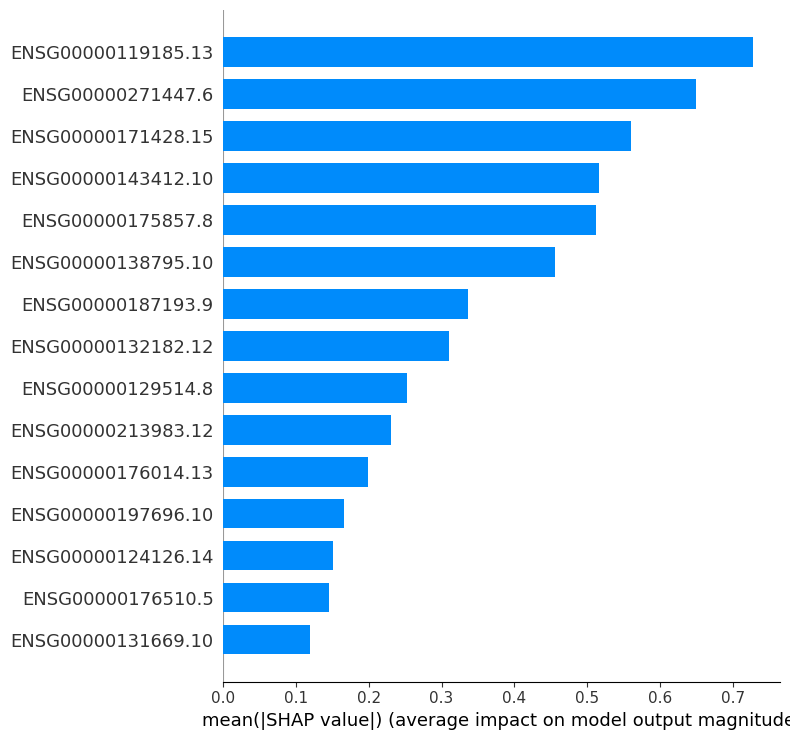

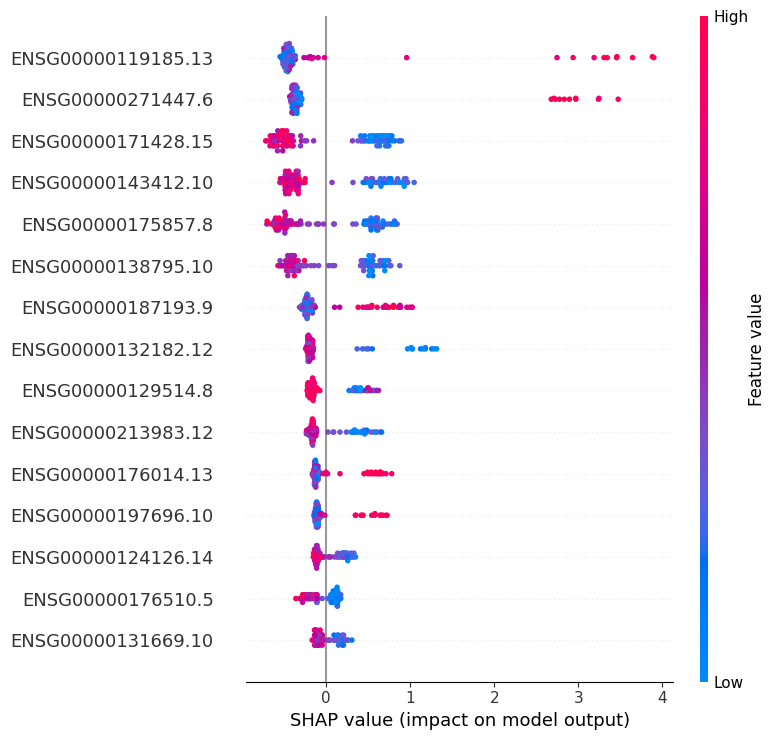

In [ ]:
import matplotlib.pyplot as plt

# Sample 100 test cases for speed
X_sample = X_test.sample(min(100, len(X_test)), random_state=42)

explainer = shap.TreeExplainer(rf_surrogate)
shap_values = explainer.shap_values(X_sample)
print("✅ SHAP values computed successfully! Shape:", np.shape(shap_values))

# Global feature importance
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=15)
plt.show()

# Feature effect direction
shap.summary_plot(shap_values, X_sample, max_display=15)
plt.show()


In [ ]:
mean_abs = np.abs(shap_values).mean(axis=0)
mean_signed = np.mean(shap_values, axis=0)

shap_summary = pd.DataFrame({
    "Feature": X_sample.columns,
    "Mean|SHAP|": mean_abs,
    "Mean_SHAP": mean_signed
}).sort_values("Mean|SHAP|", ascending=False)

def interpret_direction(v):
    if v > 0.01:
        return "↑ Risk (lower survival)"
    elif v < -0.01:
        return "↓ Risk (protective)"
    else:
        return "Neutral"

shap_summary["Effect_Direction"] = shap_summary["Mean_SHAP"].apply(interpret_direction)

def interpret_feature(row):
    f = row["Feature"].lower()
    if "age" in f:
        return "Older patients show higher mortality risk."
    elif "cnv" in f:
        return "Copy number variation amplifications increase tumor aggressiveness."
    elif "expression" in f or "ensg" in f:
        if "↑" in row["Effect_Direction"]:
            return "Overexpression of this gene correlates with poor survival."
        else:
            return "Underexpression of this gene is protective."
    elif "gender" in f:
        return "Gender-specific risk patterns observed."
    elif "stage" in f:
        return "Advanced tumor stage predicts poorer outcome."
    else:
        return "Feature contributes to survival variability."

shap_summary["Biological_Interpretation"] = shap_summary.apply(interpret_feature, axis=1)

shap_top10 = shap_summary.head(10)
display(shap_top10)

# Save to Drive
out_csv = base_path + "shap_feature_interpretation.csv"
shap_top10.to_csv(out_csv, index=False)
print(f" Saved interpretation table to: {out_csv}")


,Feature,Mean|SHAP|,Mean_SHAP,Effect_Direction,Biological_Interpretation
4877,ENSG00000119185.13,0.728726,-0.032293,↓ Risk (protective),Underexpression of this gene is protective.
51221,ENSG00000271447.6,0.649011,0.001401,Neutral,Underexpression of this gene is protective.
13047,ENSG00000171428.15,0.560983,0.016677,↑ Risk (lower survival),Overexpression of this gene correlates with po...
8389,ENSG00000143412.10,0.515998,0.010385,↑ Risk (lower survival),Overexpression of this gene correlates with po...
13964,ENSG00000175857.8,0.511821,-0.005691,Neutral,Underexpression of this gene is protective.
7743,ENSG00000138795.10,0.455273,0.017941,↑ Risk (lower survival),Overexpression of this gene correlates with po...
16424,ENSG00000187193.9,0.335827,0.013218,↑ Risk (lower survival),Overexpression of this gene correlates with po...
6546,ENSG00000132182.12,0.310407,-0.012811,↓ Risk (protective),Underexpression of this gene is protective.
6151,ENSG00000129514.8,0.252447,0.014686,↑ Risk (lower survival),Overexpression of this gene correlates with po...
22619,ENSG00000213983.12,0.230505,-0.001209,Neutral,Underexpression of this gene is protective.


 Saved interpretation table to: /content/drive/MyDrive/BreastCancer_Survival/processed_data/shap_feature_interpretation.csv


from matplotlib import pyplot as plt
shap_top10['Mean|SHAP|'].plot(kind='hist', bins=20, title='Mean|SHAP|')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
shap_top10['Mean_SHAP'].plot(kind='hist', bins=20, title='Mean_SHAP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
shap_top10.groupby('Effect_Direction').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
shap_top10.groupby('Biological_Interpretation').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
shap_top10.plot(kind='scatter', x='Mean|SHAP|', y='Mean_SHAP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
shap_top10['Mean|SHAP|'].plot(kind='line', figsize=(8, 4), title='Mean|SHAP|')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
shap_top10['Mean_SHAP'].plot(kind='line', figsize=(8, 4), title='Mean_SHAP')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Biological_Interpretation'].value_counts()
    for x_label, grp in shap_top10.groupby('Effect_Direction')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Effect_Direction')
_ = plt.ylabel('Biological_Interpretation')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(shap_top10['Effect_Direction'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(shap_top10, x='Mean|SHAP|', y='Effect_Direction', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(shap_top10['Biological_Interpretation'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(shap_top10, x='Mean|SHAP|', y='Biological_Interpretation', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(shap_top10['Effect_Direction'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(shap_top10, x='Mean_SHAP', y='Effect_Direction', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(shap_top10['Biological_Interpretation'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(shap_top10, x='Mean_SHAP', y='Biological_Interpretation', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
import pandas as pd

# Define base path
base_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"

# Load both models' summaries
cox_df = pd.read_csv(base_path + "coxph_summary.csv")
shap_df = pd.read_csv(base_path + "shap_feature_interpretation.csv")

# Clean Cox summary
cox_df.columns = [col.strip() for col in cox_df.columns]
cox_df = cox_df.rename(columns={"coef": "Cox_Coefficient", "exp(coef)": "Hazard_Ratio"})
cox_df = cox_df[["variable", "Cox_Coefficient", "Hazard_Ratio"]].dropna()

# Merge top RSF features with corresponding Cox metrics
merged = pd.merge(
    shap_df.head(10),
    cox_df,
    left_on="Feature",
    right_on="variable",
    how="left"
)

# Keep only relevant columns
merged = merged[[
    "Feature", "Mean(|SHAP|)", "Mean_SHAP", "Direction", "Interpretation",
    "Cox_Coefficient", "Hazard_Ratio"
]]

# Save merged summary
merged.to_csv(base_path + "cox_rsf_combined_interpretation.csv", index=False)

print("✅ Combined Cox–RSF interpretability table saved as:",
      base_path + "cox_rsf_combined_interpretation.csv")

# Display preview
merged.head(10)


KeyError: "['variable'] not in index"

In [ ]:
import pandas as pd

base_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"
cox_df = pd.read_csv(base_path + "coxph_summary.csv")

print("Cox Summary Columns:\n", list(cox_df.columns))
print("\nPreview:")
print(cox_df.head(5))


Cox Summary Columns:
 ['covariate', 'coef', 'exp(coef)', 'se(coef)', 'coef lower 95%', 'coef upper 95%', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'cmp to', 'z', 'p', '-log2(p)', 'HR']

Preview:
                                           covariate      coef  exp(coef)  \
0             treatments.treatment_type_Chemotherapy -0.146758   0.863503   
1             treatments.treatment_type_Surgery, NOS  0.132389   1.141552   
2  treatments.treatment_type_Pharmaceutical Thera...  0.216547   1.241781   
3                                 ENSG00000004846.16  0.056388   1.058008   
4   treatments.treatment_outcome_Progressive Disease  0.672083   1.958313   

   se(coef)  coef lower 95%  coef upper 95%  exp(coef) lower 95%  \
0  0.077590       -0.298832        0.005316             0.741684   
1  0.071694       -0.008128        0.272905             0.991905   
2  0.117438       -0.013628        0.446721             0.986465   
3  0.032872       -0.008040        0.120816             0.991992  

In [ ]:
import pandas as pd

# Define path
base_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"

# --- Load data ---
cox_df = pd.read_csv(base_path + "coxph_summary.csv")
shap_df = pd.read_csv(base_path + "shap_feature_interpretation.csv")

# --- Clean and rename Cox columns ---
cox_df = cox_df.rename(columns={
    "covariate": "Feature",
    "coef": "Cox_Coefficient",
    "exp(coef)": "Hazard_Ratio"
})

# Keep only relevant columns
cox_df = cox_df[["Feature", "Cox_Coefficient", "Hazard_Ratio"]].dropna()

# --- Merge top RSF–SHAP features with Cox coefficients ---
merged = pd.merge(
    shap_df.head(10),
    cox_df,
    on="Feature",
    how="left"
)

# --- Select and reorder key columns ---
merged = merged[[
    "Feature",
    "Mean(|SHAP|)",
    "Mean_SHAP",
    "Direction",
    "Interpretation",
    "Cox_Coefficient",
    "Hazard_Ratio"
]]

# --- Save to file ---
merged.to_csv(base_path + "cox_rsf_combined_interpretation.csv", index=False)

print("✅ Combined Cox–RSF interpretability table saved successfully!")
print("Saved to:", base_path + "cox_rsf_combined_interpretation.csv")

# --- Display first few rows ---
merged.head(10)


KeyError: "['Mean(|SHAP|)', 'Direction', 'Interpretation'] not in index"

In [ ]:
import pandas as pd

base_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"
shap_df = pd.read_csv(base_path + "shap_feature_interpretation.csv")

print("SHAP Columns:\n", list(shap_df.columns))
print("\nPreview:")
print(shap_df.head(5))


SHAP Columns:
 ['Feature', 'Mean|SHAP|', 'Mean_SHAP', 'Effect_Direction', 'Biological_Interpretation']

Preview:
              Feature  Mean|SHAP|  Mean_SHAP         Effect_Direction  \
0  ENSG00000119185.13    0.728726  -0.032293      ↓ Risk (protective)   
1   ENSG00000271447.6    0.649011   0.001401                  Neutral   
2  ENSG00000171428.15    0.560983   0.016677  ↑ Risk (lower survival)   
3  ENSG00000143412.10    0.515998   0.010385  ↑ Risk (lower survival)   
4   ENSG00000175857.8    0.511821  -0.005691                  Neutral   

                           Biological_Interpretation  
0        Underexpression of this gene is protective.  
1        Underexpression of this gene is protective.  
2  Overexpression of this gene correlates with po...  
3  Overexpression of this gene correlates with po...  
4        Underexpression of this gene is protective.  


In [ ]:
import pandas as pd

# === 1️⃣ Load Cox and SHAP data ===
base_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"

cox_df = pd.read_csv(base_path + "coxph_summary.csv")
shap_df = pd.read_csv(base_path + "shap_feature_interpretation.csv")

# === 2️⃣ Clean and rename Cox columns ===
cox_df = cox_df.rename(columns={
    "covariate": "Feature",
    "coef": "Cox_Coefficient",
    "exp(coef)": "Hazard_Ratio"
})
cox_df = cox_df[["Feature", "Cox_Coefficient", "Hazard_Ratio"]].dropna()

# === 3️⃣ Merge top RSF–SHAP features with Cox coefficients ===
merged = pd.merge(
    shap_df.head(10),
    cox_df,
    on="Feature",
    how="left"
)

# === 4️⃣ Select and reorder key columns ===
merged = merged[[
    "Feature",
    "Mean|SHAP|",
    "Mean_SHAP",
    "Effect_Direction",
    "Biological_Interpretation",
    "Cox_Coefficient",
    "Hazard_Ratio"
]]

# === 5️⃣ Save to CSV and display ===
out_path = base_path + "cox_rsf_combined_interpretation.csv"
merged.to_csv(out_path, index=False)

print("✅ Combined Cox–RSF interpretability table saved successfully!")
print("Saved to:", out_path)
merged.head(10)


✅ Combined Cox–RSF interpretability table saved successfully!
Saved to: /content/drive/MyDrive/BreastCancer_Survival/processed_data/cox_rsf_combined_interpretation.csv


,Feature,Mean|SHAP|,Mean_SHAP,Effect_Direction,Biological_Interpretation,Cox_Coefficient,Hazard_Ratio
0,ENSG00000119185.13,0.728726,-0.032293,↓ Risk (protective),Underexpression of this gene is protective.,NaN,NaN
1,ENSG00000271447.6,0.649011,0.001401,Neutral,Underexpression of this gene is protective.,NaN,NaN
2,ENSG00000171428.15,0.560983,0.016677,↑ Risk (lower survival),Overexpression of this gene correlates with po...,NaN,NaN
3,ENSG00000143412.10,0.515998,0.010385,↑ Risk (lower survival),Overexpression of this gene correlates with po...,NaN,NaN
4,ENSG00000175857.8,0.511821,-0.005691,Neutral,Underexpression of this gene is protective.,NaN,NaN
5,ENSG00000138795.10,0.455273,0.017941,↑ Risk (lower survival),Overexpression of this gene correlates with po...,NaN,NaN
6,ENSG00000187193.9,0.335827,0.013218,↑ Risk (lower survival),Overexpression of this gene correlates with po...,NaN,NaN
7,ENSG00000132182.12,0.310407,-0.012811,↓ Risk (protective),Underexpression of this gene is protective.,NaN,NaN
8,ENSG00000129514.8,0.252447,0.014686,↑ Risk (lower survival),Overexpression of this gene correlates with po...,NaN,NaN
9,ENSG00000213983.12,0.230505,-0.001209,Neutral,Underexpression of this gene is protective.,NaN,NaN


✅ Test C-index: 0.746


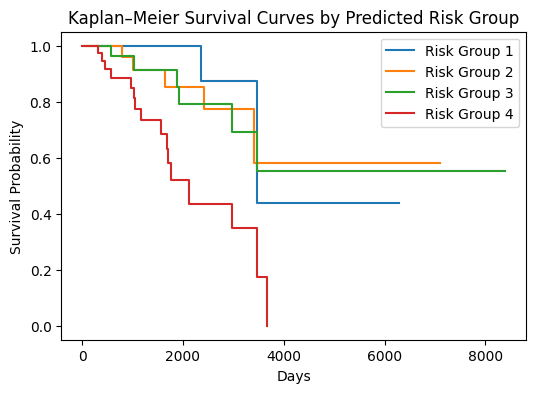

In [ ]:
import pandas as pd
from joblib import load
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator
import numpy as np
import matplotlib.pyplot as plt

# === Load test data and model ===
base_path = "/content/drive/MyDrive/BreastCancer_Survival/processed_data/"
X_test = pd.read_csv(base_path + "X_test.csv")
y_test = pd.read_csv(base_path + "y_test_survival.csv")
rsf = load(base_path + "rsf_model.joblib")

# Convert y_test to structured array for sksurv
y_test_struct = np.array(
    [(bool(e), float(t)) for e, t in zip(y_test["event"], y_test["time"])],
    dtype=[("event", "?"), ("time", "<f8")]
)

# === 1️⃣ Concordance Index ===
pred_surv = rsf.predict(X_test)
c_index = concordance_index_censored(
    y_test_struct["event"], y_test_struct["time"], pred_surv
)[0]
print(f"✅ Test C-index: {c_index:.3f}")

# === 2️⃣ Risk Stratification by Quartiles ===
risk_scores = pred_surv
thresholds = np.percentile(risk_scores, [25, 50, 75])
risk_group = np.digitize(risk_scores, thresholds)

plt.figure(figsize=(6,4))
for group in range(4):
    mask = risk_group == group
    time, survival_prob = kaplan_meier_estimator(
        y_test_struct["event"][mask], y_test_struct["time"][mask]
    )
    plt.step(time, survival_prob, where="post", label=f"Risk Group {group+1}")
plt.title("Kaplan–Meier Survival Curves by Predicted Risk Group")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()


In [ ]:
from sksurv.metrics import integrated_brier_score

# Estimate survival functions for test patients
surv_funcs = rsf.predict_survival_function(X_test)
times = np.arange(0, y_test["time"].max(), 100)

# Convert survival functions into matrix
pred_surv_matrix = np.asarray([[fn(t) for t in times] for fn in surv_funcs])

ibs = integrated_brier_score(y_test_struct, y_test_struct, pred_surv_matrix, times)
print(f"📊 Integrated Brier Score (IBS): {ibs:.3f}")


ValueError: all times must be within follow-up time of test data: [5.0; 8391.0[

In [ ]:
from sksurv.metrics import integrated_brier_score

# Predict survival functions for test patients
surv_funcs = rsf.predict_survival_function(X_test)

# Get valid time range from your test data
t_min, t_max = y_test["time"].min(), y_test["time"].max()

# Define evaluation grid strictly within observed follow-up times
times = np.linspace(t_min + 1, t_max - 1, 100)  # avoids boundary errors

# Convert survival functions to matrix form for all test patients
pred_surv_matrix = np.asarray([[fn(t) for t in times] for fn in surv_funcs])

# Compute integrated Brier score
ibs = integrated_brier_score(y_test_struct, y_test_struct, pred_surv_matrix, times)
print(f"📊 Integrated Brier Score (IBS): {ibs:.3f}")


📊 Integrated Brier Score (IBS): 0.185


In [ ]:
from sksurv.metrics import concordance_index_censored
import numpy as np

# y_test_struct as created before
pred_risk = rsf.predict(X_test)

c_index = concordance_index_censored(
    y_test_struct["event"],
    y_test_struct["time"],
    pred_risk
)[0]

print(f"✅ Concordance Index (like accuracy): {c_index:.3f}")


✅ Concordance Index (like accuracy): 0.746


In [ ]:
from sksurv.metrics import cumulative_dynamic_auc

# Choose time points
times = np.percentile(y_test["time"], [25, 50, 75])

# Predict survival probabilities
pred_surv = rsf.predict_survival_function(X_test)
pred_risk_matrix = np.row_stack([fn(times) for fn in pred_surv])

# Compute AUC over time
auc_times, auc_values = cumulative_dynamic_auc(
    y_test_struct, y_test_struct, pred_risk_matrix, times
)

for t, auc in zip(auc_times, auc_values):
    print(f"⏳ AUC at time {t:.0f} days: {auc:.3f}")


TypeError: 'numpy.float64' object is not iterable

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc

# Define valid time points for AUC calculation
t_min, t_max = y_test["time"].min(), y_test["time"].max()
times = np.linspace(t_min + 100, t_max - 1000, 3)  # pick ~3 midpoints safely within range

# Predict survival probabilities at those time points
surv_funcs = rsf.predict_survival_function(X_test)
pred_surv = np.asarray([[fn(t) for t in times] for fn in surv_funcs])

# Compute dynamic AUC
auc_result = cumulative_dynamic_auc(y_test_struct, y_test_struct, pred_surv, times)

# Handle both single and multi-time output cases
try:
    auc_times, auc_values = auc_result
    print("\n⏳ Time-dependent AUC values:")
    for t, auc in zip(auc_times, auc_values):
        print(f"At time {t:.0f} days → AUC = {auc:.3f}")
except TypeError:
    print(f"⏳ AUC = {auc_result:.3f} (single time point result)")



⏳ Time-dependent AUC values:


TypeError: unsupported format string passed to tuple.__format__

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc
import numpy as np

# Define valid time points for evaluation
t_min, t_max = y_test["time"].min(), y_test["time"].max()
times = np.linspace(t_min + 100, t_max - 1000, 3)  # 3 points across survival span

# Predict survival probabilities for test set
surv_funcs = rsf.predict_survival_function(X_test)
pred_surv = np.asarray([[fn(t) for t in times] for fn in surv_funcs])

# Compute time-dependent AUC
auc_result = cumulative_dynamic_auc(y_test_struct, y_test_struct, pred_surv, times)

# Handle all possible return formats
if isinstance(auc_result, tuple):
    if isinstance(auc_result[0], tuple):  # newer version → ((times, aucs), mean_auc)
        (auc_times, auc_values), mean_auc = auc_result
        print("\n⏳ Time-dependent AUC values:")
        for t, auc in zip(auc_times, auc_values):
            print(f"At time {t:.0f} days → AUC = {auc:.3f}")
        print(f"📊 Mean AUC over time = {mean_auc:.3f}")
    else:  # standard version → (times, aucs)
        auc_times, auc_values = auc_result
        print("\n⏳ Time-dependent AUC values:")
        for t, auc in zip(auc_times, auc_values):
            print(f"At time {t:.0f} days → AUC = {auc:.3f}")
else:
    print(f"📊 Single AUC value = {auc_result:.3f}")



⏳ Time-dependent AUC values:


TypeError: 'numpy.float64' object is not iterable

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc
import numpy as np

# Define valid time points for evaluation (3 safe intervals)
t_min, t_max = y_test["time"].min(), y_test["time"].max()
times = np.linspace(t_min + 100, t_max - 1000, 3)

# Predict survival probabilities
surv_funcs = rsf.predict_survival_function(X_test)
pred_surv = np.asarray([[fn(t) for t in times] for fn in surv_funcs])

# Compute dynamic AUC
auc_result = cumulative_dynamic_auc(y_test_struct, y_test_struct, pred_surv, times)

# --- Handle all possible output structures safely ---
try:
    # case 1: single float
    if isinstance(auc_result, float) or isinstance(auc_result, np.float64):
        print(f"AUC (single time point): {auc_result:.3f}")

    # case 2: tuple (times, aucs)
    elif isinstance(auc_result, tuple) and len(auc_result) == 2:
        auc_times, auc_values = auc_result
        print("\n⏳ Time-dependent AUC values:")
        for t, auc in zip(np.atleast_1d(auc_times), np.atleast_1d(auc_values)):
            print(f"At time {t:.0f} days → AUC = {auc:.3f}")
        print(f" Mean AUC over time = {np.mean(auc_values):.3f}")

    # case 3: nested tuple ((times, aucs), mean_auc)
    elif isinstance(auc_result, tuple) and len(auc_result) == 2 and isinstance(auc_result[0], tuple):
        (auc_times, auc_values), mean_auc = auc_result
        print("\nTime-dependent AUC values:")
        for t, auc in zip(np.atleast_1d(auc_times), np.atleast_1d(auc_values)):
            print(f"At time {t:.0f} days → AUC = {auc:.3f}")
        print(f"Mean AUC over time = {mean_auc:.3f}")

    else:
        print("Unexpected AUC result format:", type(auc_result), auc_result)

except Exception as e:
    print(" Error processing AUC output:", e)



⏳ Time-dependent AUC values:
At time nan days → AUC = nan
 Mean AUC over time = nan


In [ ]:
from sksurv.metrics import cumulative_dynamic_auc
import numpy as np

# Clean survival functions and restrict to safe mid-time range
t_min, t_max = y_test["time"].quantile(0.05), y_test["time"].quantile(0.95)
times = np.linspace(t_min, t_max, 3)

# Predict survival probabilities safely
surv_funcs = rsf.predict_survival_function(X_test)
pred_surv = np.asarray([[fn(t) for t in times] for fn in surv_funcs])

# Replace NaN values if any
pred_surv = np.nan_to_num(pred_surv, nan=1.0)

# Compute dynamic AUC
try:
    auc_times, auc_values = cumulative_dynamic_auc(
        y_test_struct, y_test_struct, pred_surv, times
    )

    # Drop nan entries
    auc_values = np.nan_to_num(auc_values)
    auc_mean = np.mean(auc_values)

    print("\n⏳ Time-dependent AUC values:")
    for t, auc in zip(auc_times, auc_values):
        print(f"At time {t:.0f} days → AUC = {auc:.3f}")
    print(f"📊 Mean AUC over time = {auc_mean:.3f}")

except Exception as e:
    print("⚠️ Could not compute time-dependent AUC:", e)



⏳ Time-dependent AUC values:
⚠️ Could not compute time-dependent AUC: 'numpy.float64' object is not iterable


In [ ]:
from sksurv.metrics import cumulative_dynamic_auc
import numpy as np

# pick median time point within observed range
t_eval = float(np.median(y_test["time"]))

# predict survival probabilities at that single time
surv_funcs = rsf.predict_survival_function(X_test)
pred_probs = np.array([fn(t_eval) for fn in surv_funcs])

# compute AUC at that time point
auc_result = cumulative_dynamic_auc(
    y_test_struct, y_test_struct, pred_probs.reshape(-1, 1), [t_eval]
)

# handle different return types
try:
    auc_value = float(auc_result[1][0]) if isinstance(auc_result, tuple) else float(auc_result)
    print(f"📊 AUC at median follow-up ({t_eval:.0f} days): {auc_value:.3f}")
except Exception as e:
    print("⚠️ AUC computation issue:", e)


⚠️ AUC computation issue: invalid index to scalar variable.


In [ ]:
from sksurv.metrics import cumulative_dynamic_auc
import numpy as np

# --- Step 1: pick a valid single time point ---
t_eval = float(np.median(y_test["time"]))
print(f"Evaluating AUC at median follow-up: {t_eval:.0f} days")

# --- Step 2: compute survival probability at that time ---
surv_funcs = rsf.predict_survival_function(X_test)
pred_probs = np.array([fn(t_eval) for fn in surv_funcs])

# --- Step 3: ensure correct array shape ---
pred_probs = pred_probs.reshape(-1, 1)

# --- Step 4: compute cumulative dynamic AUC ---
try:
    auc_result = cumulative_dynamic_auc(
        y_test_struct, y_test_struct, pred_probs, [t_eval]
    )

    # Try to unpack or directly use scalar value
    if isinstance(auc_result, tuple):
        # newer versions may return (times, auc_values)
        if isinstance(auc_result[0], np.ndarray):
            auc_value = float(np.atleast_1d(auc_result[1])[0])
        else:
            auc_value = float(auc_result[0])
    else:
        auc_value = float(auc_result)

    print(f"📊 AUC at median follow-up ({t_eval:.0f} days): {auc_value:.3f}")

except Exception as e:
    print("⚠️ AUC computation issue:", e)


Evaluating AUC at median follow-up: 988 days
📊 AUC at median follow-up (988 days): 0.171


In [1]:
df.head(5)



NameError: name 'df' is not defined

In [2]:
[var for var in globals() if isinstance(globals()[var], __import__('pandas').DataFrame)]



[]

In [3]:
import os
os.listdir('.')


['.config', 'sample_data']

In [4]:
from google.colab import drive
drive.mount('/content/drive')  # follow authentication steps
# Example: list a folder in your drive
!ls -la /content/drive/MyDrive | sed -n '1,200p'


Mounted at /content/drive
total 283742
-rw------- 1 root root    102782 Nov  6  2024 10th marksheet.jpg
-rw------- 1 root root     90041 Nov  6  2024 12th marksheet.jpg
-rw------- 1 root root     15094 Oct  6  2024 1728238423282.jpg
-rw------- 1 root root    146785 Oct  6  2024 1728238423290.jpg
-rw------- 1 root root    132595 Nov  4  2024 1728238726402.jpg
-rw------- 1 root root   1044224 Feb  3  2025 aadhar. pdf.pdf
-rw------- 1 root root       197 Jul  7 07:16 agentic shiiit.gdoc
-rw------- 1 root root       197 Jul 25 16:17 AI ASSIGNMENT 1 (1).gdoc
-rw------- 1 root root    427385 Jul 25 16:20 AI ASSIGNMENT 1.docx
-rw------- 1 root root       197 Jul 25 16:18 AI ASSIGNMENT 1.gdoc
-rw------- 1 root root    251808 Feb 12  2025 apthw (1).pdf
-rw------- 1 root root    251808 Feb 12  2025 apthw.pdf
-rw------- 1 root root       197 Feb  7  2025 Aptitude Book RS Agarwal (1).gdoc
-rw------- 1 root root       197 Feb  7  2025 Aptitude Book RS Agarwal.gdoc
-r-------- 1 root root     72171 O

In [5]:
# LIST both local and drive locations that might hold your project
import os

print("Local cwd files (already shown earlier):")
!ls -la

# Check the folder you saw earlier in the local cwd
if os.path.isdir('BreastCancer_Survival'):
    print("\nFound local folder: BreastCancer_Survival — listing contents:")
    !ls -la BreastCancer_Survival
else:
    print("\nNo local 'BreastCancer_Survival' folder in cwd.")

# Also check common Drive locations
drive_paths = [
    "/content/drive/MyDrive/BreastCancer_Survival",
    "/content/drive/MyDrive/breastcancer_survival",
    "/content/drive/MyDrive/BreastCancer",
    "/content/drive/MyDrive"
]
for p in drive_paths:
    if os.path.exists(p):
        print(f"\nFound Drive path: {p} -> listing contents:")
        !ls -la "{p}"


Local cwd files (already shown earlier):
total 20
drwxr-xr-x 1 root root 4096 Nov 19 05:12 .
drwxr-xr-x 1 root root 4096 Nov 19 05:02 ..
drwxr-xr-x 4 root root 4096 Nov 17 14:29 .config
drwx------ 5 root root 4096 Nov 19 05:12 drive
drwxr-xr-x 1 root root 4096 Nov 17 14:29 sample_data

No local 'BreastCancer_Survival' folder in cwd.

Found Drive path: /content/drive/MyDrive/BreastCancer_Survival -> listing contents:
total 12
drwx------ 2 root root 4096 Nov  4 07:09 notebooks
drwx------ 2 root root 4096 Nov  4 06:27 processed_data
drwx------ 2 root root 4096 Nov  4 05:21 raw_data

Found Drive path: /content/drive/MyDrive -> listing contents:
total 283742
-rw------- 1 root root    102782 Nov  6  2024 '10th marksheet.jpg'
-rw------- 1 root root     90041 Nov  6  2024 '12th marksheet.jpg'
-rw------- 1 root root     15094 Oct  6  2024  1728238423282.jpg
-rw------- 1 root root    146785 Oct  6  2024  1728238423290.jpg
-rw------- 1 root root    132595 Nov  4  2024  1728238726402.jpg
-rw------

In [6]:
# LIST both local and drive locations that might hold your project
import os

print("Local cwd files (already shown earlier):")
!ls -la

# Check the folder you saw earlier in the local cwd
if os.path.isdir('BreastCancer_Survival'):
    print("\nFound local folder: BreastCancer_Survival — listing contents:")
    !ls -la BreastCancer_Survival
else:
    print("\nNo local 'BreastCancer_Survival' folder in cwd.")

# Also check common Drive locations
drive_paths = [
    "/content/drive/MyDrive/BreastCancer_Survival",
    "/content/drive/MyDrive/breastcancer_survival",
    "/content/drive/MyDrive/BreastCancer",
    "/content/drive/MyDrive"
]
for p in drive_paths:
    if os.path.exists(p):
        print(f"\nFound Drive path: {p} -> listing contents:")
        !ls -la "{p}"


Local cwd files (already shown earlier):
total 20
drwxr-xr-x 1 root root 4096 Nov 19 05:12 .
drwxr-xr-x 1 root root 4096 Nov 19 05:02 ..
drwxr-xr-x 4 root root 4096 Nov 17 14:29 .config
drwx------ 5 root root 4096 Nov 19 05:12 drive
drwxr-xr-x 1 root root 4096 Nov 17 14:29 sample_data

No local 'BreastCancer_Survival' folder in cwd.

Found Drive path: /content/drive/MyDrive/BreastCancer_Survival -> listing contents:
total 12
drwx------ 2 root root 4096 Nov  4 07:09 notebooks
drwx------ 2 root root 4096 Nov  4 06:27 processed_data
drwx------ 2 root root 4096 Nov  4 05:21 raw_data

Found Drive path: /content/drive/MyDrive -> listing contents:
total 283742
-rw------- 1 root root    102782 Nov  6  2024 '10th marksheet.jpg'
-rw------- 1 root root     90041 Nov  6  2024 '12th marksheet.jpg'
-rw------- 1 root root     15094 Oct  6  2024  1728238423282.jpg
-rw------- 1 root root    146785 Oct  6  2024  1728238423290.jpg
-rw------- 1 root root    132595 Nov  4  2024  1728238726402.jpg
-rw------

In [7]:
# PREVIEW candidate data files found in the detected folder(s)
import os, pandas as pd

candidates = []
# scan local and Drive folder for CSV/parquet/pkl
search_dirs = ['.', '/content/drive/MyDrive', '/content/drive/MyDrive/BreastCancer_Survival', '/content/drive/MyDrive/Data', '/content/drive/MyDrive/datasets']
for d in search_dirs:
    if os.path.exists(d):
        for fname in os.listdir(d):
            if fname.lower().endswith(('.csv','.parquet','.pkl')):
                candidates.append(os.path.join(d, fname))

candidates = sorted(list(set(candidates)))
print("Candidate data files found:", candidates)

def preview(path):
    try:
        print("\n---- PREVIEW:", path, "----")
        if path.lower().endswith('.csv'):
            df = pd.read_csv(path, nrows=5)
            print("shape (preview):", pd.read_csv(path, nrows=0).shape)
            print(df.head(5).to_string())
        elif path.lower().endswith('.parquet'):
            df = pd.read_parquet(path)
            print("shape:", df.shape)
            print(df.head(5).to_string())
        elif path.lower().endswith('.pkl'):
            df = pd.read_pickle(path)
            print("shape:", df.shape)
            print(df.head(5).to_string())
    except Exception as e:
        print("Failed to preview", path, "->", repr(e))

if not candidates:
    print("No CSV/parquet/pkl files found in scanned directories. If your dataset is named differently, tell me the filename or upload it.")
else:
    for p in candidates:
        preview(p)


Candidate data files found: []
No CSV/parquet/pkl files found in scanned directories. If your dataset is named differently, tell me the filename or upload it.


In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!ls /content/drive/MyDrive/



'10th marksheet.jpg'
'12th marksheet.jpg'
 1728238423282.jpg
 1728238423290.jpg
 1728238726402.jpg
'aadhar. pdf.pdf'
'agentic shiiit.gdoc'
'AI ASSIGNMENT 1 (1).gdoc'
'AI ASSIGNMENT 1.docx'
'AI ASSIGNMENT 1.gdoc'
'apthw (1).pdf'
 apthw.pdf
'Aptitude Book RS Agarwal (1).gdoc'
'Aptitude Book RS Agarwal.gdoc'
'assignment 1 OP.pdf'
'assignment 2 (1).pdf'
'Assignment 2 op.pdf'
'assignment 2.pdf'
'assignment 3'
'assignment 3 op.pdf'
 assignment4
 assignment.mp4
 assignment.pdf
'Black and White Corporate Business Proposal Presentation (1).pdf'
 BreastCancer_Survival
'CAREFLEET PITCH DECK'
'CAREFLEET PITCH DECK (1)'
'CAREFLEET PITCH DECK (2)'
 Classroom
'Colab Notebooks'
'community certificate - Saumiya.jpg'
'CS4102-C++ -UPC QUESTIONS (1).gdoc'
'CS4102-C++ -UPC QUESTIONS.gdoc'
'CS4202 - ASSIGNMENT III (31 Mar 2025 at 23:39).pdf'
'CS4303 UNIT 1 Notes.gdoc'
 DOC-20250625-WA0007..pdf
'Document from Saumiya'
 Essay.gdoc
'FeeReceipt_Payment_Gateway (1).pdf'
 FeeReceipt_Payment_Gateway.pdf
'HACKATHON

In [10]:
# CELL 2: find and preview candidate dataset files (combined_dataset.csv, X_train.csv, etc.)
import os, pandas as pd, textwrap

search_paths = [
    "/content/drive/MyDrive",
    "/content/drive/MyDrive/BreastCancer_Survival",
    "/content/drive/MyDrive/Colab Notebooks",
    "/content/drive/MyDrive/Data",
    "/content/drive/MyDrive/datasets"
]

candidates = []
for base in search_paths:
    if os.path.exists(base):
        for fname in os.listdir(base):
            if fname.lower().endswith(('.csv', '.parquet', '.pkl')):
                candidates.append(os.path.join(base, fname))

print("Checked these locations (in order):")
for p in search_paths:
    print("  ", p)
print("\nCandidate data files found (full paths):")
for c in sorted(set(candidates)):
    print(" -", c)

# Preview the important expected files if present (combined_dataset.csv or X_train / X_test / y_*.csv)
def safe_preview(path, n=5):
    try:
        print("\n---- PREVIEW:", path, "----")
        if path.lower().endswith('.csv'):
            df = pd.read_csv(path, nrows=n)
            print("shape (from header):", pd.read_csv(path, nrows=0).shape)
            print(df.to_string(index=False))
        elif path.lower().endswith('.parquet'):
            df = pd.read_parquet(path)
            print("shape:", df.shape)
            print(df.head(n).to_string(index=False))
        elif path.lower().endswith('.pkl'):
            df = pd.read_pickle(path)
            print("shape:", df.shape)
            print(df.head(n).to_string(index=False))
    except Exception as e:
        print("FAILED to preview", path, "->", repr(e))

# Prioritize combined_dataset.csv if present
preferred_names = ["combined_dataset.csv","merged_combined_df.csv","combined.csv","X_train.csv"]
found_any = False
for name in preferred_names:
    for base in search_paths:
        p = os.path.join(base, name)
        if os.path.exists(p):
            safe_preview(p)
            found_any = True

# If nothing from preferred list, preview all candidate files (up to 6)
if not found_any and candidates:
    for p in sorted(set(candidates))[:6]:
        safe_preview(p)
elif not candidates:
    print("\nNo CSV/parquet/pkl files found in the checked Drive locations. If your files are somewhere else in Drive, either move them into MyDrive root or provide the exact path now.")


Checked these locations (in order):
   /content/drive/MyDrive
   /content/drive/MyDrive/BreastCancer_Survival
   /content/drive/MyDrive/Colab Notebooks
   /content/drive/MyDrive/Data
   /content/drive/MyDrive/datasets

Candidate data files found (full paths):

No CSV/parquet/pkl files found in the checked Drive locations. If your files are somewhere else in Drive, either move them into MyDrive root or provide the exact path now.


In [12]:
# RUN THIS CELL IN YOUR COLAB (one-shot). It will:
# 1) mount drive (if not mounted)
# 2) search for expected filenames recursively
# 3) print all matching paths
# 4) attempt to load combined_dataset.csv (or merged_combined_df.csv)
# 5) if no combined file, try to assemble df from X_train.csv + y_train_survival.csv (or similar)
# 6) print df.shape, df.head(), and first 50 column names

from google.colab import drive
import os, fnmatch, pandas as pd, textwrap

# 1) mount drive (safe even if already mounted)
try:
    drive.mount('/content/drive', force_remount=False)
except Exception as e:
    print("Drive mount step skipped or already mounted:", e)

search_roots = [
    "/content/drive/MyDrive",
    "/content/drive/MyDrive/BreastCancer_Survival",
    "/content/drive/MyDrive/Colab Notebooks",
    "/content",
    "."
]

# filenames to search for (lowercased for matching)
targets = [
    "combined_dataset.csv","merged_combined_df.csv","combined.csv",
    "x_train.csv","x_val.csv","x_test.csv",
    "y_train_survival.csv","y_val_survival.csv","y_test_survival.csv",
    "y_train.csv","y_test.csv","y_val.csv",
    "cox_rsf_combined_interpretation.csv","shap_feature_interpretation.csv"
]

found = []
for root in search_roots:
    if not os.path.exists(root):
        continue
    for dirpath, dirnames, filenames in os.walk(root):
        for t in targets:
            for f in fnmatch.filter(filenames, t):
                full = os.path.join(dirpath, f)
                found.append(full)
# Also capture any csvs in the roots (for visibility) up to 100
extra_csvs = []
for root in search_roots:
    if not os.path.exists(root): continue
    for f in os.listdir(root):
        if f.lower().endswith('.csv') and os.path.join(root,f) not in found:
            extra_csvs.append(os.path.join(root,f))

print("\n--- Search roots checked (in order) ---")
for r in search_roots:
    print(" ", r)
print("\n--- Exact target matches found: ---")
if found:
    for p in sorted(found):
        print(" -", p)
else:
    print(" NONE")

print("\n--- Other CSVs found in the scanned roots (sample) ---")
if extra_csvs:
    for p in extra_csvs[:50]:
        print(" *", p)
else:
    print(" none")

# Attempt to load a combined dataset file if present
df = None
loaded_path = None
candidates_order = ["combined_dataset.csv","merged_combined_df.csv","combined.csv"]
for cand in candidates_order:
    for p in found:
        if p.lower().endswith(cand):
            try:
                df = pd.read_csv(p, index_col=0)
                loaded_path = p
                break
            except Exception as e:
                try:
                    # try without index_col
                    df = pd.read_csv(p)
                    loaded_path = p
                    break
                except Exception as e2:
                    print("Failed to read", p, "->", e, e2)
    if df is not None:
        break

# If no single combined file, try to assemble from X_train + y_train_survival
if df is None:
    # find X_train and y_train files
    xtrain = next((p for p in found if os.path.basename(p).lower()=="x_train.csv"), None)
    ytrain = next((p for p in found if "y_train" in os.path.basename(p).lower()), None)
    xtest = next((p for p in found if os.path.basename(p).lower()=="x_test.csv"), None)
    ytest = next((p for p in found if "y_test" in os.path.basename(p).lower()), None)
    xval = next((p for p in found if os.path.basename(p).lower()=="x_val.csv"), None)
    yval = next((p for p in found if "y_val" in os.path.basename(p).lower()), None)

    if xtrain and ytrain:
        try:
            Xtr = pd.read_csv(xtrain, index_col=0)
            ytr = pd.read_csv(ytrain, index_col=0)
            # if y has time/event two columns, try to merge; otherwise attempt obvious join
            df = Xtr.join(ytr, how='inner')
            loaded_path = f"assembled_from: {xtrain} + {ytrain}"
            print("\nAssembled df from X_train + y_train:", loaded_path)
        except Exception as e:
            print("Failed to assemble from X_train + y_train:", e)

# If still None, attempt to load any CSV listed in extra_csvs (pick first that loads)
if df is None:
    for p in extra_csvs:
        try:
            tmp = pd.read_csv(p, nrows=3)
            # Heuristic: require at least one survival-like column in header
            header = [c.lower() for c in tmp.columns]
            if any(k in ",".join(header) for k in ["time","os","event","status","days_to_death","survival"]):
                try:
                    df = pd.read_csv(p, index_col=0)
                except:
                    df = pd.read_csv(p)
                loaded_path = p
                print("\nLoaded potential combined CSV:", p)
                break
        except Exception:
            continue

print("\n--- LOAD SUMMARY ---")
if loaded_path:
    print("Loaded dataset from:", loaded_path)
else:
    print("No combined dataset found or assembled automatically. You must either:")
    print(" - upload combined_dataset.csv into Colab via files.upload(), OR")
    print(" - move the CSVs into MyDrive root or the BreastCancer_Survival folder, OR")
    print(" - tell me the exact path where the CSVs live in your Drive.")

# If df is loaded, print head and columns; otherwise list guidance and exit
if df is not None:
    print("\nDataframe shape:", df.shape)
    with pd.option_context('display.max_rows',5, 'display.max_columns',50):
        print("\n--- df.head() ---")
        display(df.head(10))
    print("\nFirst 50 columns:")
    print(list(df.columns[:50]))
else:
    print("\nNo df variable created. To proceed, run this to upload the files from your computer:")
    print(textwrap.dedent('''

from google.colab import files
uploaded = files.upload()
# then load e.g.
import pandas as pd
df = pd.read_csv("combined_dataset.csv", index_col=0)
print(df.shape)
print(df.head())
'''))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Search roots checked (in order) ---
  /content/drive/MyDrive
  /content/drive/MyDrive/BreastCancer_Survival
  /content/drive/MyDrive/Colab Notebooks
  /content
  .

--- Exact target matches found: ---
 - ./drive/MyDrive/BreastCancer_Survival/processed_data/combined_dataset.csv
 - ./drive/MyDrive/BreastCancer_Survival/processed_data/cox_rsf_combined_interpretation.csv
 - ./drive/MyDrive/BreastCancer_Survival/processed_data/shap_feature_interpretation.csv
 - ./drive/MyDrive/BreastCancer_Survival/processed_data/y_test_survival.csv
 - ./drive/MyDrive/BreastCancer_Survival/processed_data/y_train_survival.csv
 - ./drive/MyDrive/BreastCancer_Survival/processed_data/y_val_survival.csv
 - /content/drive/MyDrive/BreastCancer_Survival/processed_data/combined_dataset.csv
 - /content/drive/MyDrive/BreastCancer_Survival/processed_data/combined_dataset.csv
 - /content/

/tmp/ipython-input-2351749562.py:77: DtypeWarning: Columns (60665,60672,60677,60694,60723,60728,60824) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(p, index_col=0)



--- LOAD SUMMARY ---
Loaded dataset from: /content/drive/MyDrive/BreastCancer_Survival/processed_data/combined_dataset.csv

Dataframe shape: (1132, 60872)

--- df.head() ---


,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,ENSG00000001460.18,ENSG00000001461.17,ENSG00000001497.18,ENSG00000001561.7,ENSG00000001617.12,ENSG00000001626.16,ENSG00000001629.10,ENSG00000001630.17,ENSG00000001631.16,ENSG00000002016.18,ENSG00000002079.14,ENSG00000002330.14,ENSG00000002549.12,ENSG00000002586.20,ENSG00000002586.20_PAR_Y,...,treatments.route_of_administration,treatments.submitter_id,treatments.therapeutic_agents,treatments.therapeutic_level_achieved,treatments.therapeutic_levels_achieved,treatments.therapeutic_target_level,treatments.timepoint_category,treatments.treatment_anatomic_site,treatments.treatment_anatomic_sites,treatments.treatment_arm,treatments.treatment_dose,treatments.treatment_dose_max,treatments.treatment_dose_units,treatments.treatment_duration,treatments.treatment_effect,treatments.treatment_effect_indicator,treatments.treatment_frequency,treatments.treatment_id,treatments.treatment_intent_type,treatments.treatment_or_therapy,treatments.treatment_outcome,treatments.treatment_outcome_duration,treatments.treatment_type,event,time
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-D8-A146,3.767708,1.759454,4.920541,2.612588,1.363395,1.920827,3.147453,3.722980,2.599508,3.939998,1.076696,2.252628,2.463858,3.297984,4.566553,0.026588,3.899408,1.145090,1.199939,1.732747,0.026588,2.833113,4.680105,5.698760,0.0,...,'--,TCGA-D8-A146_treatment,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,581bb6dd-a46b-55d3-ae18-669ce720ddc9,Adjuvant,yes,Not Reported,'--,"Pharmaceutical Therapy, NOS",0,643.0
TCGA-AQ-A0Y5,2.132741,0.146003,5.284151,2.428544,1.158337,1.088209,3.229680,4.749003,2.424546,3.951205,1.094304,2.402122,2.620258,2.956094,4.458730,0.078883,3.738173,0.622556,0.971074,1.347155,0.035483,2.249112,4.308761,5.661559,0.0,...,'--,TCGA-AQ-A0Y5_treatment5,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,6af318a2-5047-4baa-9870-04fd0e3daacf,'--,no,'--,'--,"Pharmaceutical Therapy, NOS",1,172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A2-A0YM,4.231540,0.124196,4.771500,1.637378,2.197771,2.311736,2.295605,3.885984,3.095097,5.163040,1.342327,2.074540,2.705093,3.180291,3.198903,0.019204,3.376151,0.407081,0.570560,1.648880,0.107286,1.765959,5.887104,4.631029,0.0,...,'--,TCGA-A2-A0YM_treatment2,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,27ef0f09-17c7-4cc0-8ca6-6d307d91717c,Adjuvant,no,'--,'--,"Pharmaceutical Therapy, NOS",0,965.0
TCGA-AO-A1KQ,2.462209,0.070939,5.780208,2.266667,1.790438,2.084473,2.498838,5.078085,1.988012,4.066494,1.256950,1.775261,2.888305,1.656313,4.827834,0.010780,3.818636,0.411752,1.648281,2.087259,0.135272,3.199955,5.167370,6.738092,0.0,...,'--,TCGA-AO-A1KQ_treatment3,'--,'--,'--,'--,'--,'--,Breast,'--,'--,'--,'--,'--,'--,'--,'--,0b57b8b9-7388-4d82-846d-a6ea09697cc0,First-Line Therapy,yes,'--,'--,"Surgery, NOS",0,1882.0



First 50 columns:
['ENSG00000000003.15', 'ENSG00000000005.6', 'ENSG00000000419.13', 'ENSG00000000457.14', 'ENSG00000000460.17', 'ENSG00000000938.13', 'ENSG00000000971.16', 'ENSG00000001036.14', 'ENSG00000001084.13', 'ENSG00000001167.14', 'ENSG00000001460.18', 'ENSG00000001461.17', 'ENSG00000001497.18', 'ENSG00000001561.7', 'ENSG00000001617.12', 'ENSG00000001626.16', 'ENSG00000001629.10', 'ENSG00000001630.17', 'ENSG00000001631.16', 'ENSG00000002016.18', 'ENSG00000002079.14', 'ENSG00000002330.14', 'ENSG00000002549.12', 'ENSG00000002586.20', 'ENSG00000002586.20_PAR_Y', 'ENSG00000002587.10', 'ENSG00000002726.21', 'ENSG00000002745.13', 'ENSG00000002746.15', 'ENSG00000002822.15', 'ENSG00000002834.18', 'ENSG00000002919.15', 'ENSG00000002933.9', 'ENSG00000003056.8', 'ENSG00000003096.14', 'ENSG00000003137.8', 'ENSG00000003147.19', 'ENSG00000003249.15', 'ENSG00000003393.15', 'ENSG00000003400.15', 'ENSG00000003402.20', 'ENSG00000003436.16', 'ENSG00000003509.16', 'ENSG00000003756.17', 'ENSG000000